In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def greedy_compress(g, indice):
    x = g[indice]

    zero_indices = (x == 0)
    nonzero_indices = (x != 0)

    y = x[nonzero_indices]

    power = torch.maximum(-torch.round(torch.log2(torch.abs(y))), torch.zeros_like(y))
    bits = torch.ceil(torch.log2(power + 1))

    y = torch.sign(y) / (2**power)

    x[nonzero_indices] = y

    result = torch.zeros_like(g)
    result[indice] = x

    return result

In [5]:
import torch
from torch.func import functional_call

def mirror_descent(model, X_train, y_train, param_name, impact: torch.Tensor, lr, eta, lambda_value, num_steps, criterion):
    impact = impact.clone().detach().requires_grad_(True)
    original_param = dict(model.named_parameters())[param_name]

    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    param_grad = torch.autograd.grad(loss, original_param, create_graph=True)[0]
    new_params = {name: param.clone() for name, param in model.named_parameters()}

    for _ in range(num_steps):
        # Update parameter using impact
        param_new = original_param - lr * impact * param_grad
        # Create new parameter dictionary
        new_params[param_name] = param_new
        # Compute outputs with new parameters
        outputs_new = functional_call(model, new_params, (X_train,))
        # Compute new loss
        loss_new = criterion(outputs_new, y_train)

        # Compute gradient of new loss w.r.t. impact
        grad_impact = torch.autograd.grad(loss_new, impact)[0]

        with torch.no_grad():
            impact_update = torch.pow(impact, 1/(1+eta*lambda_value)) * torch.exp(-(eta/(1+eta*lambda_value)) * (grad_impact))
            impact = impact_update / impact_update.sum()

        # Ensure impact requires grad for the next iteration
        impact.requires_grad_(True)

    return impact.detach()


def gradient_descent(model, X_train, y_train, param_name, impact: torch.Tensor, lr, eta, num_steps, criterion):
    impact = impact.clone().detach().requires_grad_(True)
    original_param = dict(model.named_parameters())[param_name]

    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    param_grad = torch.autograd.grad(loss, original_param, create_graph=True)[0]
    new_params = {name: param.clone() for name, param in model.named_parameters()}

    for _ in range(num_steps):
        # Update parameter using impact
        param_new = original_param - lr * impact * param_grad
        # Create new parameter dictionary
        new_params[param_name] = param_new
        # Compute outputs with new parameters
        outputs_new = functional_call(model, new_params, (X_train,))
        # Compute new loss
        loss_new = criterion(outputs_new, y_train)

        # Compute gradient of new loss w.r.t. impact
        grad_impact = torch.autograd.grad(loss_new, impact)[0]

        with torch.no_grad():
            impact -= eta * lr * grad_impact
            impact = torch.clip(impact, 0, 1)
        
        # Ensure impact requires grad for the next iteration
        impact.requires_grad_(True)

    return impact.detach()

In [8]:
from math import ceil
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

def train(model, optimizer, criterion, train_dataset, val_dataset, num_epochs, compression_type, lr, param_usage=0.2, error_feedback=False, num_steps=100, plot=False):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    w = {}
    for epoch in trange(num_epochs):
        print('\nEpoch: %d' % epoch)
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
#         if error_feedback:
#             g = {name: torch.zeros_like(param)
#                 for name, param in model.named_parameters()
#             }
#             c = {name: torch.zeros_like(param)
#                 for name, param in model.named_parameters()
#             }
        
        if epoch == 0 and (compression_type == 'mirror_descent_stochastic'\
                           or compression_type == 'mirror_descent_greedy'\
                           or compression_type == 'mirror_descent_greedy_weighted'\
                           or compression_type == 'mirror_descent_greedy_topk'\
                           or compression_type == 'mirror_descent_weighted_greedy'):
            w = {name: (imp := torch.rand_like(param)) / imp.sum()
                for name, param in model.named_parameters()
            }
        if epoch == 0 and compression_type == 'gradient_descent_weighted_greedy':
            w = {name: torch.ones_like(param)/2 for name, param in model.named_parameters()}
        
        for batch_idx, (inputs, targets) in enumerate(train_dataset):
            inputs, targets = inputs.to(device), targets.to(device)
            if batch_idx == 0 and (compression_type == 'mirror_descent_stochastic'\
                                   or compression_type == 'mirror_descent_greedy'\
                                   or compression_type == 'mirror_descent_greedy_weighted'\
                                   or compression_type == 'mirror_descent_greedy_topk'\
                                   or compression_type == 'mirror_descent_weighted_greedy'):
                for name, param in model.named_parameters():
                    w[name] = mirror_descent(
                        model=model,
                        param_name=name,
                        impact=w[name],
                        lr=lr,
                        eta=2.,
                        lambda_value=0.1,
                        num_steps=num_steps,
                        X_train=inputs,
                        y_train=targets,
                        criterion=criterion
                    )
            if batch_idx == 0 and compression_type == 'gradient_descent_weighted_greedy':
                for name, param in model.named_parameters():
                    w[name] = gradient_descent(
                        model=model,
                        param_name=name,
                        impact=w[name],
                        lr=lr,
                        eta=100000.,
                        num_steps=num_steps,
                        X_train=inputs,
                        y_train=targets,
                        criterion=criterion
                    )
                    if plot and 'weight' in name:
                        plt.hist(w[name].cpu().detach().flatten(), bins=50, label=name)
                        plt.show()
                        print(f'{name} min: {w[name].min():.5f}, max: {w[name].max():.5f}, min/max: {w[name].min()/w[name].max():.3f}')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            if compression_type == 'square_stochastic':
                for param in model.parameters():
                    w = param.grad.flatten()**2
                    indice = torch.multinomial(w, ceil(param_usage * len(w)))
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'square_greedy':
                for param in model.parameters():
                    w = param.grad.flatten()**2
                    indice = torch.argsort(w, descending=True)[:ceil(param_usage * len(w))]
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'random':
                for param in model.parameters():
                    w = torch.ones_like(param.grad.flatten())
                    indice = torch.multinomial(w, ceil(param_usage * len(w)))
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_stochastic':
                for name, param in model.named_parameters():
                    indice = torch.multinomial(w[name].flatten(), ceil(param_usage * len(w[name].flatten())))
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_greedy':
                for name, param in model.named_parameters():
                    indice = torch.argsort(w[name].flatten(), descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_greedy_weighted':
                for name, param in model.named_parameters():
                    indice = torch.argsort(w[name].flatten(), descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    
                    weights = torch.zeros_like(w[name])
                    weights.flatten()[indice] = w[name].flatten()[indice]
                    weights *= ceil(param_usage * len(w[name].flatten())) / weights.sum()
                    
                    param.grad *= weights.reshape(param.shape)
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_greedy_topk':
                for name, param in model.named_parameters():
                    indice1 = torch.argsort(param.grad.flatten()**2, descending=True)[:ceil(2 * param_usage * len(param.flatten()))]
                    indice2 = torch.argsort(w[name].flatten()[indice1], descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    g = torch.zeros_like(param.grad.flatten())
                    g[indice1[indice2]] = param.grad.flatten()[indice1[indice2]]
                    param.grad.copy_(greedy_compress(g, indice1[indice2]).reshape(param.shape))
            elif compression_type == 'mirror_descent_weighted_greedy':
                for name, param in model.named_parameters():
                    indice = torch.argsort((param.grad.abs() * w[name]).flatten(), descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    
                    weights = torch.zeros_like(w[name])
                    weights.flatten()[indice] = w[name].flatten()[indice]
                    weights *= ceil(param_usage * len(w[name].flatten())) / weights.sum()
                    
                    param.grad *= weights.reshape(param.shape)
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'gradient_descent_weighted_greedy':
                for name, param in model.named_parameters():
                    indice = torch.argsort((param.grad.abs() * w[name]).flatten(), descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    
                    weights = torch.zeros_like(w[name])
                    weights.flatten()[indice] = w[name].flatten()[indice]
                    
#                     param.grad *= weights
                    param.grad.copy_(greedy_compress((weights * param.grad).flatten(), indice).reshape(param.shape))
            else:
                raise ValueError(f"Compression type {compression_type} not supported")
            
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_loss /= len(train_dataset)
        train_accuracy = 100. * correct / total
        train_log.append(train_loss)
        train_acc_log.append(train_accuracy)
        
        print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)' % (train_loss, train_accuracy, correct, total))
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_dataset:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        val_loss /= len(val_dataset)
        val_accuracy = 100. * correct / total
        val_log.append(val_loss)
        val_acc_log.append(val_accuracy)
        
        print('Validation Loss: %.3f | Validation Acc: %.3f%% (%d/%d)' % (val_loss, val_accuracy, correct, total))
    
    return train_log, train_acc_log, val_log, val_acc_log

  0%|          | 0/1 [00:00<?, ?it/s]


Epoch: 0


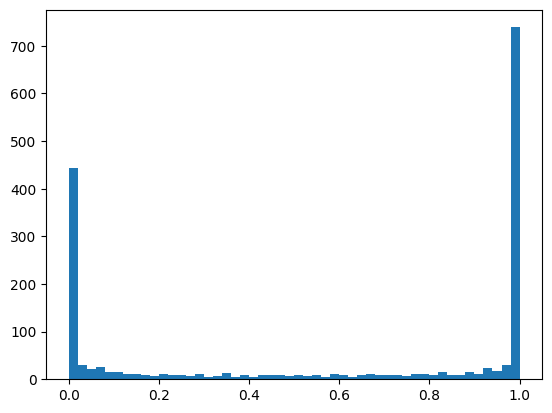

conv1.weight min: 0.00000, max: 1.00000, min/max: 0.000


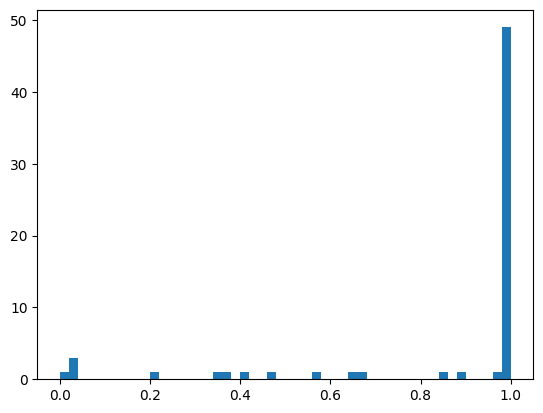

bn1.weight min: 0.00031, max: 1.00000, min/max: 0.000


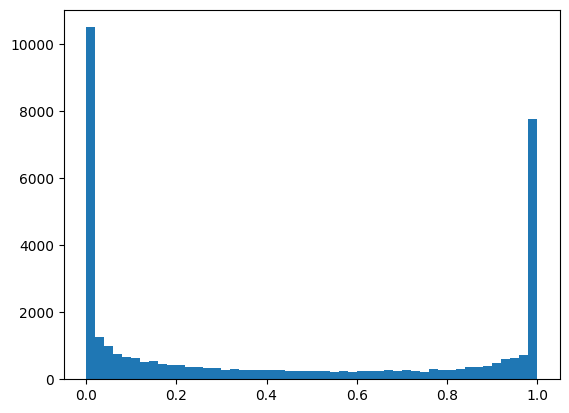

layer1.0.conv1.weight min: 0.00000, max: 1.00000, min/max: 0.000


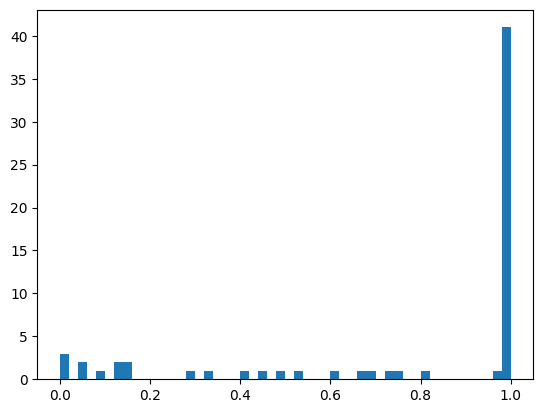

layer1.0.bn1.weight min: 0.00009, max: 1.00000, min/max: 0.000


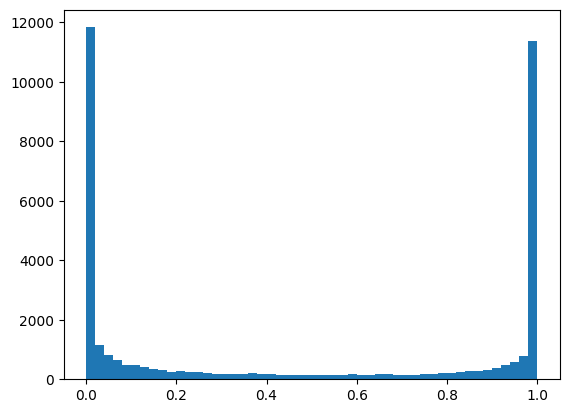

layer1.0.conv2.weight min: 0.00000, max: 1.00000, min/max: 0.000


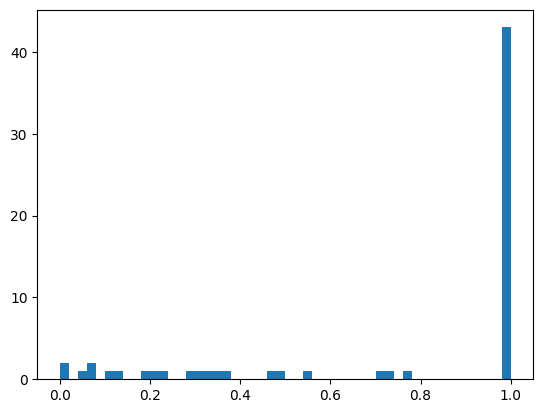

layer1.0.bn2.weight min: 0.00000, max: 1.00000, min/max: 0.000


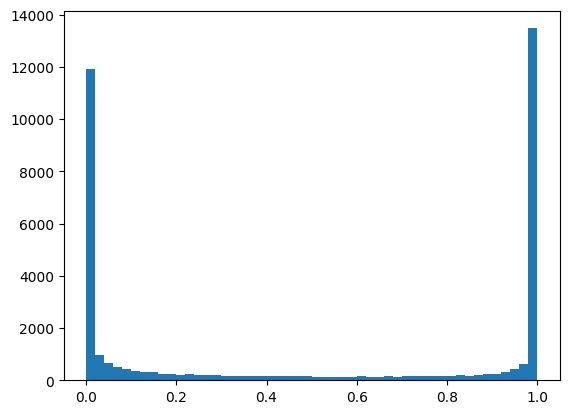

layer1.1.conv1.weight min: 0.00000, max: 1.00000, min/max: 0.000


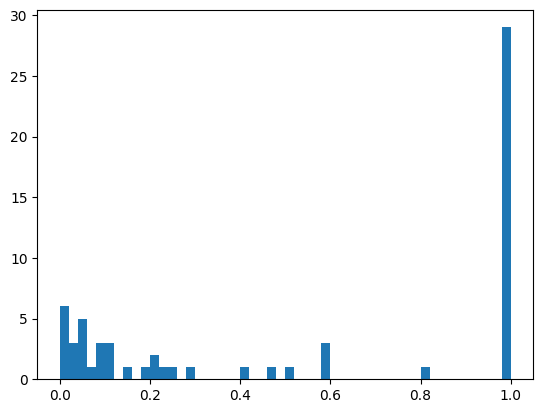

layer1.1.bn1.weight min: 0.00032, max: 1.00000, min/max: 0.000


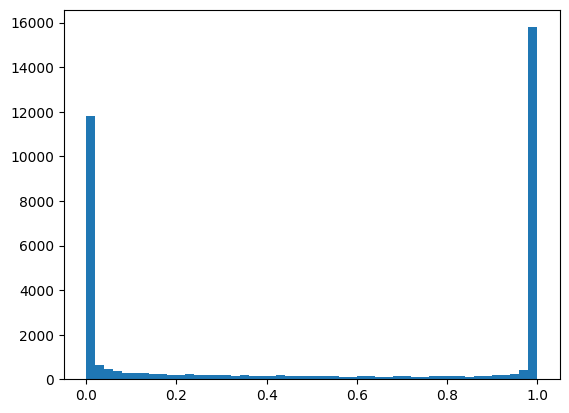

layer1.1.conv2.weight min: 0.00000, max: 1.00000, min/max: 0.000


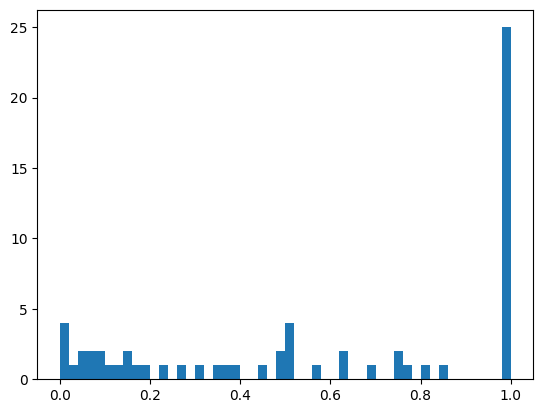

layer1.1.bn2.weight min: 0.00000, max: 1.00000, min/max: 0.000


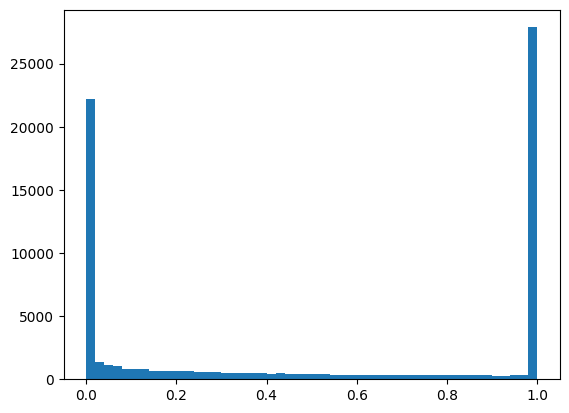

layer2.0.conv1.weight min: 0.00000, max: 1.00000, min/max: 0.000


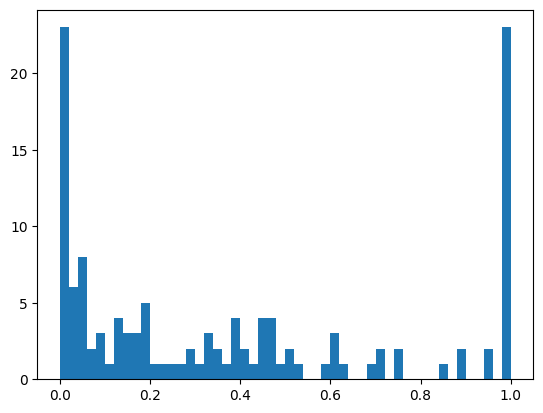

layer2.0.bn1.weight min: 0.00039, max: 1.00000, min/max: 0.000


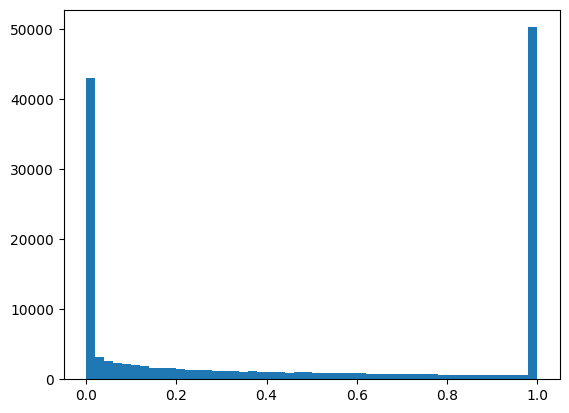

layer2.0.conv2.weight min: 0.00000, max: 1.00000, min/max: 0.000


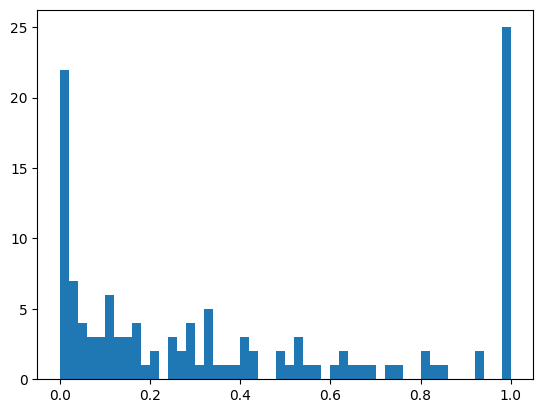

layer2.0.bn2.weight min: 0.00000, max: 1.00000, min/max: 0.000


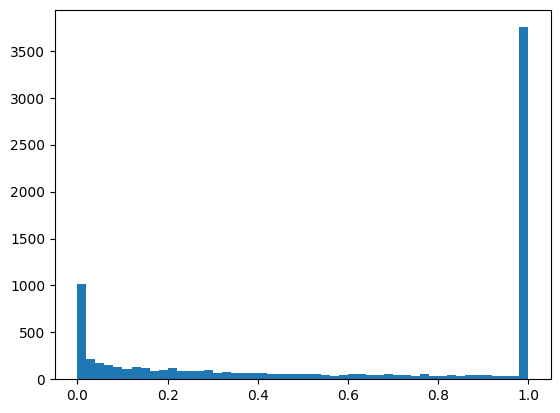

layer2.0.shortcut.0.weight min: 0.00000, max: 1.00000, min/max: 0.000


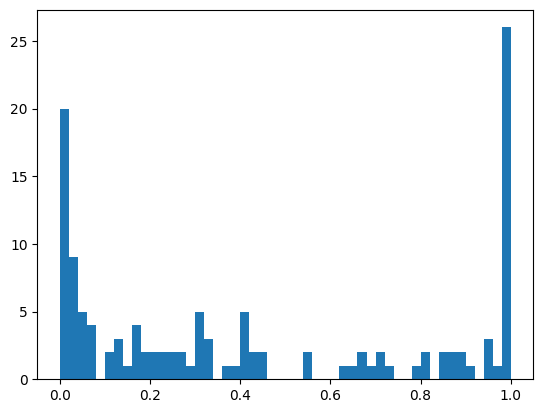

layer2.0.shortcut.1.weight min: 0.00000, max: 1.00000, min/max: 0.000


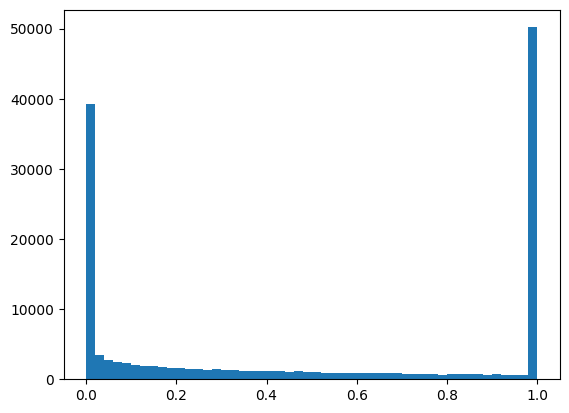

layer2.1.conv1.weight min: 0.00000, max: 1.00000, min/max: 0.000


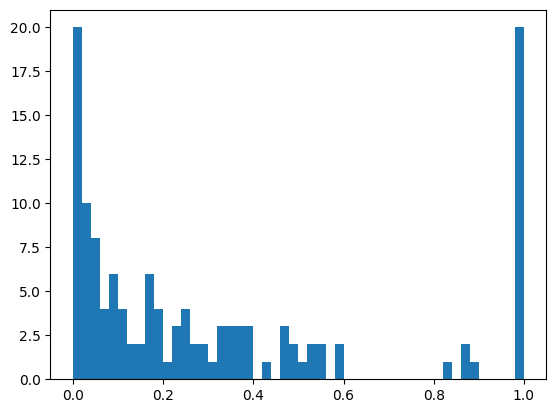

layer2.1.bn1.weight min: 0.00001, max: 1.00000, min/max: 0.000


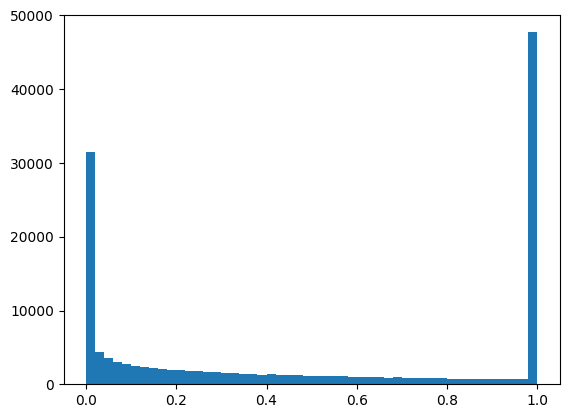

layer2.1.conv2.weight min: 0.00000, max: 1.00000, min/max: 0.000


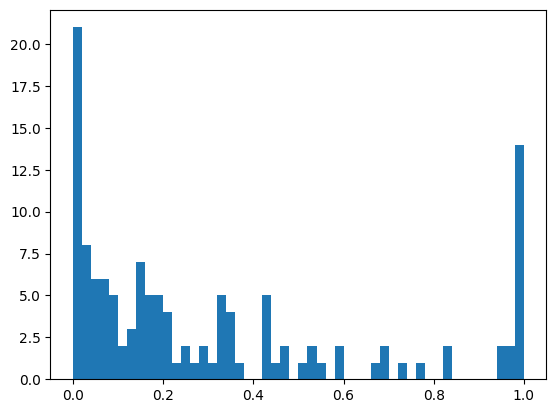

layer2.1.bn2.weight min: 0.00000, max: 1.00000, min/max: 0.000


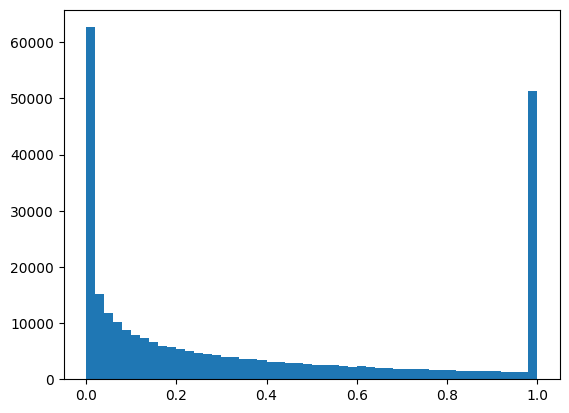

layer3.0.conv1.weight min: 0.00000, max: 1.00000, min/max: 0.000


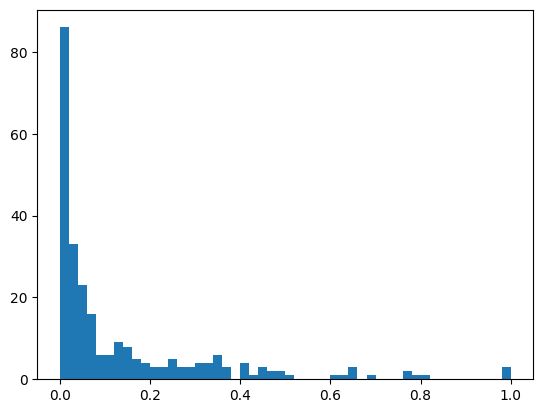

layer3.0.bn1.weight min: 0.00000, max: 1.00000, min/max: 0.000


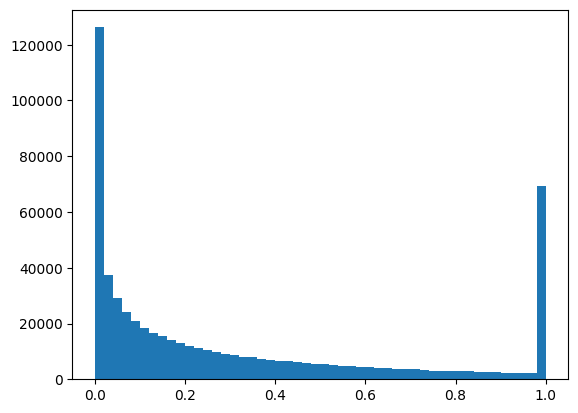

layer3.0.conv2.weight min: 0.00000, max: 1.00000, min/max: 0.000


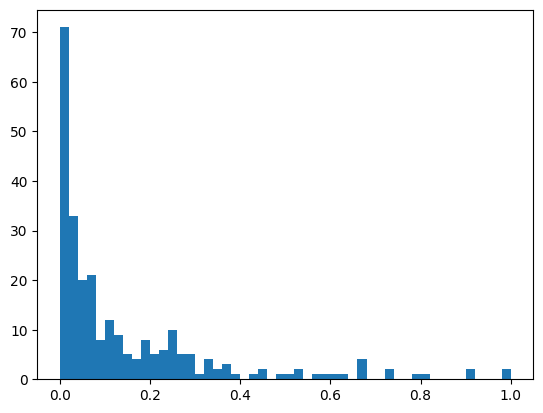

layer3.0.bn2.weight min: 0.00000, max: 1.00000, min/max: 0.000


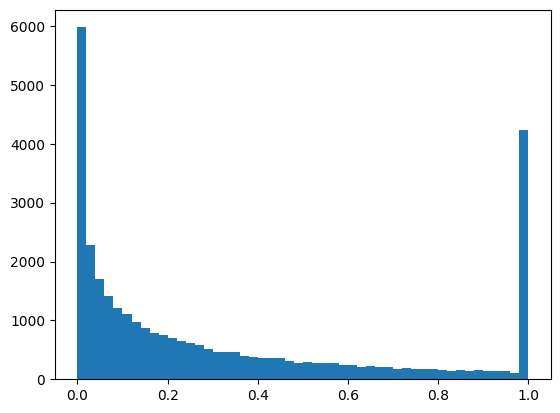

layer3.0.shortcut.0.weight min: 0.00000, max: 1.00000, min/max: 0.000


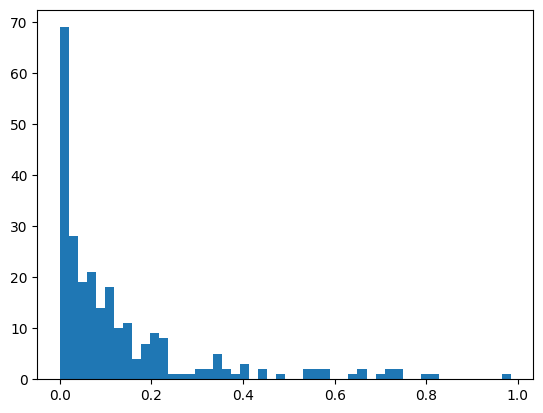

layer3.0.shortcut.1.weight min: 0.00000, max: 0.98452, min/max: 0.000


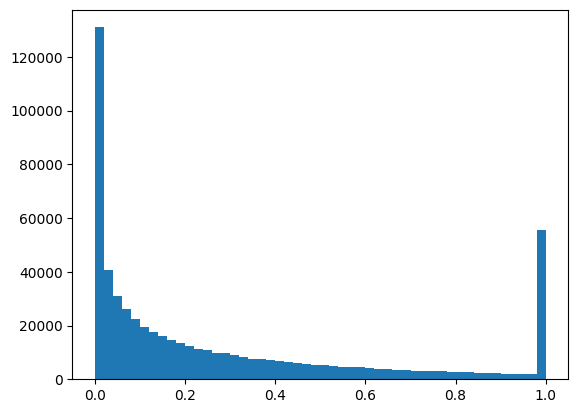

layer3.1.conv1.weight min: 0.00000, max: 1.00000, min/max: 0.000


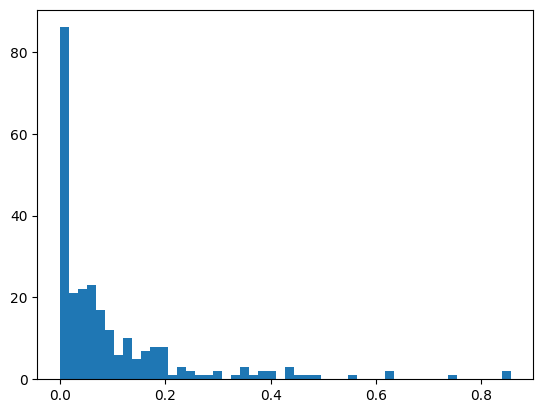

layer3.1.bn1.weight min: 0.00000, max: 0.85571, min/max: 0.000


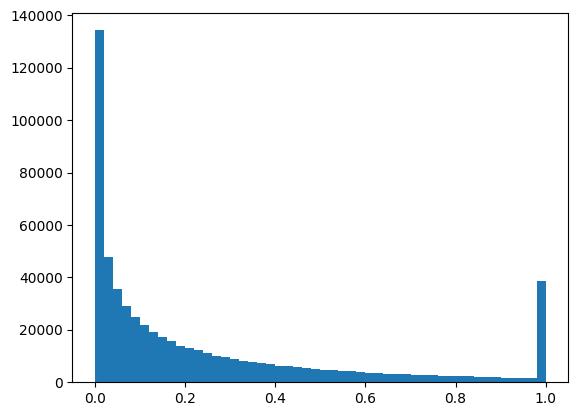

layer3.1.conv2.weight min: 0.00000, max: 1.00000, min/max: 0.000


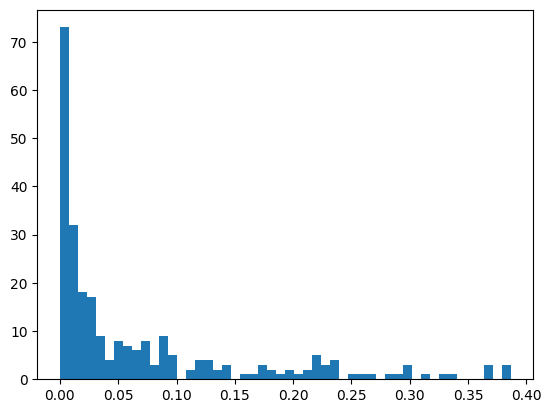

layer3.1.bn2.weight min: 0.00000, max: 0.38662, min/max: 0.000


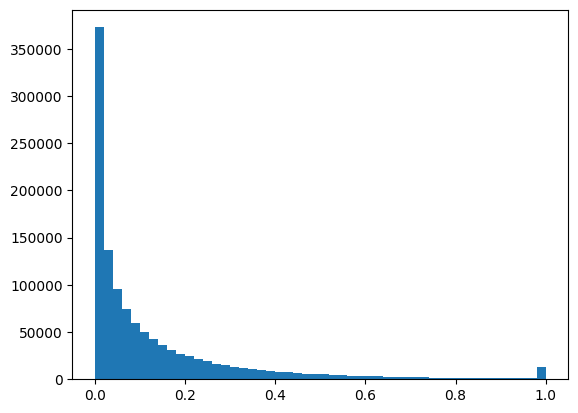

layer4.0.conv1.weight min: 0.00000, max: 1.00000, min/max: 0.000


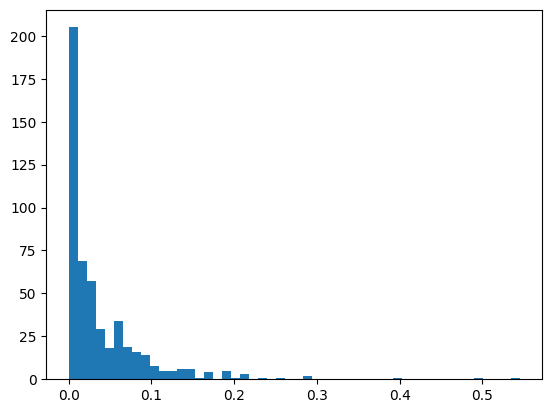

layer4.0.bn1.weight min: 0.00000, max: 0.54485, min/max: 0.000


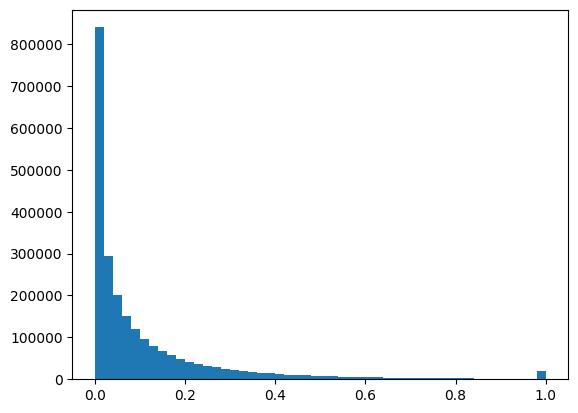

layer4.0.conv2.weight min: 0.00000, max: 1.00000, min/max: 0.000


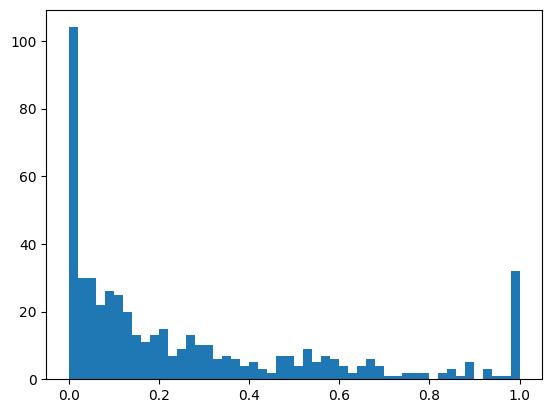

layer4.0.bn2.weight min: 0.00001, max: 1.00000, min/max: 0.000


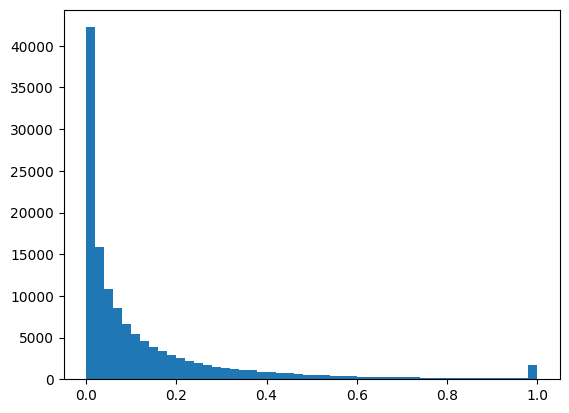

layer4.0.shortcut.0.weight min: 0.00000, max: 1.00000, min/max: 0.000


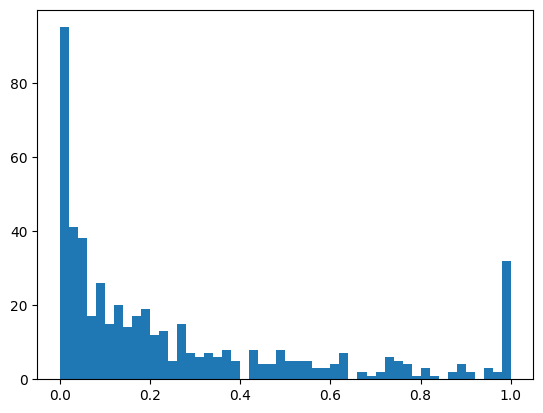

layer4.0.shortcut.1.weight min: 0.00000, max: 1.00000, min/max: 0.000


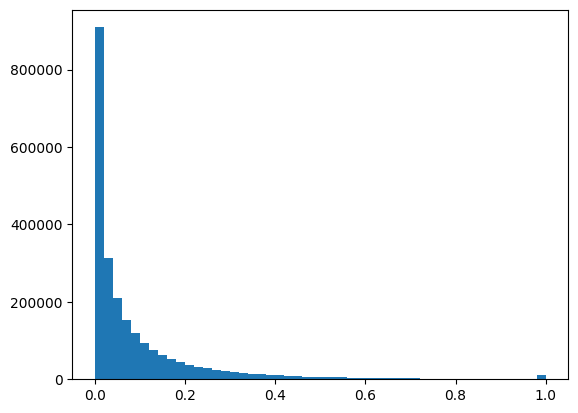

layer4.1.conv1.weight min: 0.00000, max: 1.00000, min/max: 0.000


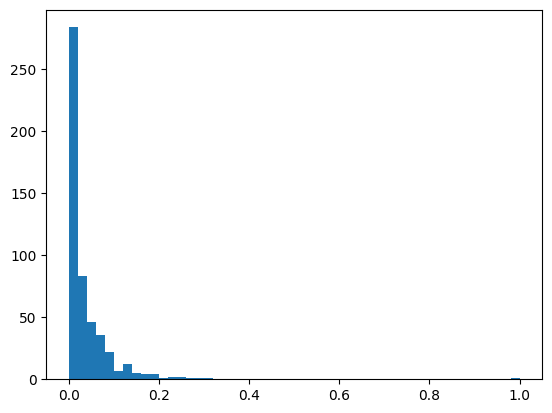

layer4.1.bn1.weight min: 0.00000, max: 1.00000, min/max: 0.000


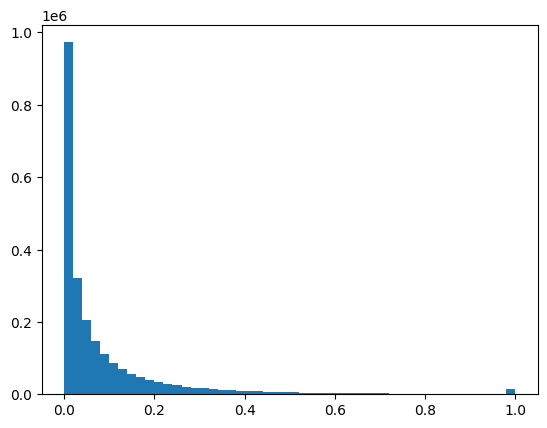

layer4.1.conv2.weight min: 0.00000, max: 1.00000, min/max: 0.000


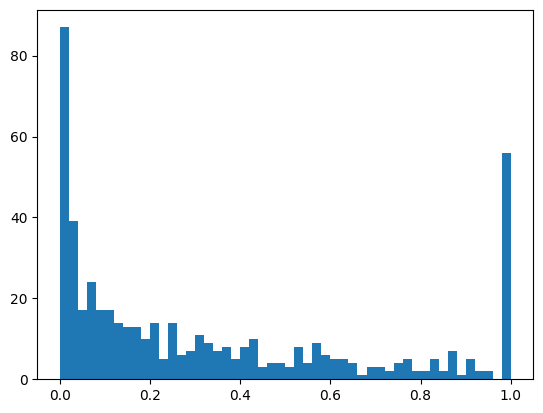

layer4.1.bn2.weight min: 0.00000, max: 1.00000, min/max: 0.000


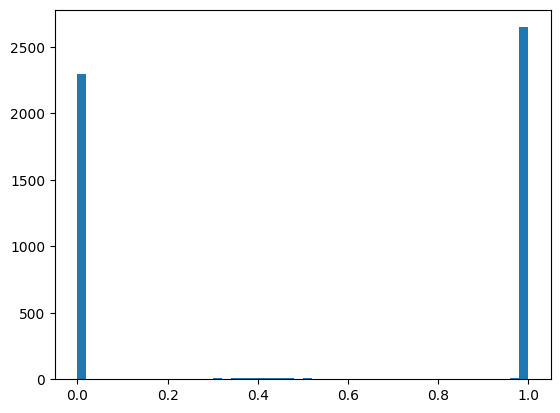

linear.weight min: 0.00000, max: 1.00000, min/max: 0.000
Train Loss: 1.843 | Train Acc: 34.428% (17214/50000)


100%|██████████| 1/1 [01:28<00:00, 88.66s/it]

Validation Loss: 1.553 | Validation Acc: 42.750% (4275/10000)


In [33]:
param_usage = 0.2
num_epochs = 1
lrs = [0.1]

compression_type = 'gradient_descent_weighted_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for lr in lrs:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[lr], train_acc[lr], test_log[lr], test_acc[lr] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr)

In [37]:
param_usage = 0.2
num_epochs = 5
lrs = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

compression_type = 'gradient_descent_weighted_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for lr in lrs:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[lr], train_acc[lr], test_log[lr], test_acc[lr] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.695 | Train Acc: 36.822% (18411/50000)


 20%|██        | 1/5 [01:22<05:30, 82.75s/it]

Validation Loss: 1.543 | Validation Acc: 44.660% (4466/10000)

Epoch: 1
Train Loss: 1.324 | Train Acc: 51.512% (25756/50000)


 40%|████      | 2/5 [02:41<04:00, 80.23s/it]

Validation Loss: 1.282 | Validation Acc: 54.300% (5430/10000)

Epoch: 2
Train Loss: 1.123 | Train Acc: 59.252% (29626/50000)


 60%|██████    | 3/5 [04:00<02:39, 79.69s/it]

Validation Loss: 1.033 | Validation Acc: 63.280% (6328/10000)

Epoch: 3
Train Loss: 0.971 | Train Acc: 65.480% (32740/50000)


 80%|████████  | 4/5 [05:19<01:19, 79.44s/it]

Validation Loss: 0.918 | Validation Acc: 67.540% (6754/10000)

Epoch: 4
Train Loss: 0.874 | Train Acc: 68.840% (34420/50000)


100%|██████████| 5/5 [06:40<00:00, 80.18s/it]


Validation Loss: 0.863 | Validation Acc: 69.480% (6948/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.587 | Train Acc: 41.288% (20644/50000)


 20%|██        | 1/5 [01:17<05:09, 77.39s/it]

Validation Loss: 1.300 | Validation Acc: 52.640% (5264/10000)

Epoch: 1
Train Loss: 1.164 | Train Acc: 57.978% (28989/50000)


 40%|████      | 2/5 [02:35<03:53, 77.86s/it]

Validation Loss: 1.043 | Validation Acc: 62.540% (6254/10000)

Epoch: 2
Train Loss: 0.949 | Train Acc: 66.352% (33176/50000)


 60%|██████    | 3/5 [03:51<02:33, 76.78s/it]

Validation Loss: 0.930 | Validation Acc: 67.390% (6739/10000)

Epoch: 3
Train Loss: 0.813 | Train Acc: 71.358% (35679/50000)


 80%|████████  | 4/5 [05:09<01:17, 77.56s/it]

Validation Loss: 0.797 | Validation Acc: 72.480% (7248/10000)

Epoch: 4
Train Loss: 0.708 | Train Acc: 75.404% (37702/50000)


100%|██████████| 5/5 [06:27<00:00, 77.49s/it]


Validation Loss: 0.794 | Validation Acc: 72.780% (7278/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.499 | Train Acc: 44.460% (22230/50000)


 20%|██        | 1/5 [01:16<05:05, 76.30s/it]

Validation Loss: 1.329 | Validation Acc: 53.280% (5328/10000)

Epoch: 1
Train Loss: 1.011 | Train Acc: 63.610% (31805/50000)


 40%|████      | 2/5 [02:36<03:56, 78.70s/it]

Validation Loss: 1.109 | Validation Acc: 61.890% (6189/10000)

Epoch: 2
Train Loss: 0.796 | Train Acc: 71.852% (35926/50000)


 60%|██████    | 3/5 [03:55<02:37, 78.59s/it]

Validation Loss: 0.784 | Validation Acc: 72.820% (7282/10000)

Epoch: 3
Train Loss: 0.660 | Train Acc: 76.978% (38489/50000)


 80%|████████  | 4/5 [05:12<01:18, 78.17s/it]

Validation Loss: 0.786 | Validation Acc: 74.230% (7423/10000)

Epoch: 4
Train Loss: 0.581 | Train Acc: 79.710% (39855/50000)


100%|██████████| 5/5 [06:31<00:00, 78.28s/it]


Validation Loss: 0.579 | Validation Acc: 80.230% (8023/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.473 | Train Acc: 46.202% (23101/50000)


 20%|██        | 1/5 [01:15<05:01, 75.47s/it]

Validation Loss: 1.288 | Validation Acc: 55.980% (5598/10000)

Epoch: 1
Train Loss: 0.980 | Train Acc: 65.226% (32613/50000)


 40%|████      | 2/5 [02:34<03:52, 77.64s/it]

Validation Loss: 0.818 | Validation Acc: 71.110% (7111/10000)

Epoch: 2
Train Loss: 0.765 | Train Acc: 73.400% (36700/50000)


 60%|██████    | 3/5 [03:52<02:35, 77.91s/it]

Validation Loss: 0.737 | Validation Acc: 74.330% (7433/10000)

Epoch: 3
Train Loss: 0.647 | Train Acc: 77.526% (38763/50000)


 80%|████████  | 4/5 [05:11<01:18, 78.21s/it]

Validation Loss: 0.690 | Validation Acc: 76.740% (7674/10000)

Epoch: 4
Train Loss: 0.565 | Train Acc: 80.434% (40217/50000)


100%|██████████| 5/5 [06:28<00:00, 77.71s/it]


Validation Loss: 0.633 | Validation Acc: 78.660% (7866/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.540 | Train Acc: 43.912% (21956/50000)


 20%|██        | 1/5 [01:19<05:17, 79.31s/it]

Validation Loss: 1.231 | Validation Acc: 55.970% (5597/10000)

Epoch: 1
Train Loss: 1.028 | Train Acc: 63.544% (31772/50000)


 40%|████      | 2/5 [02:39<03:59, 79.70s/it]

Validation Loss: 0.941 | Validation Acc: 67.560% (6756/10000)

Epoch: 2
Train Loss: 0.792 | Train Acc: 72.198% (36099/50000)


 60%|██████    | 3/5 [03:57<02:37, 78.99s/it]

Validation Loss: 1.200 | Validation Acc: 64.470% (6447/10000)

Epoch: 3
Train Loss: 0.656 | Train Acc: 77.218% (38609/50000)


 80%|████████  | 4/5 [05:17<01:19, 79.33s/it]

Validation Loss: 0.774 | Validation Acc: 73.990% (7399/10000)

Epoch: 4
Train Loss: 0.580 | Train Acc: 79.960% (39980/50000)


100%|██████████| 5/5 [06:34<00:00, 78.96s/it]


Validation Loss: 0.742 | Validation Acc: 75.600% (7560/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.662 | Train Acc: 39.642% (19821/50000)


 20%|██        | 1/5 [01:17<05:10, 77.53s/it]

Validation Loss: 1.470 | Validation Acc: 50.470% (5047/10000)

Epoch: 1
Train Loss: 1.207 | Train Acc: 56.748% (28374/50000)


 40%|████      | 2/5 [02:34<03:51, 77.29s/it]

Validation Loss: 1.294 | Validation Acc: 57.130% (5713/10000)

Epoch: 2
Train Loss: 0.935 | Train Acc: 66.908% (33454/50000)


 60%|██████    | 3/5 [03:50<02:33, 76.54s/it]

Validation Loss: 0.801 | Validation Acc: 71.880% (7188/10000)

Epoch: 3
Train Loss: 0.760 | Train Acc: 73.616% (36808/50000)


 80%|████████  | 4/5 [05:09<01:17, 77.40s/it]

Validation Loss: 0.934 | Validation Acc: 69.900% (6990/10000)

Epoch: 4
Train Loss: 0.645 | Train Acc: 77.698% (38849/50000)


100%|██████████| 5/5 [06:28<00:00, 77.70s/it]

Validation Loss: 0.686 | Validation Acc: 76.380% (7638/10000)


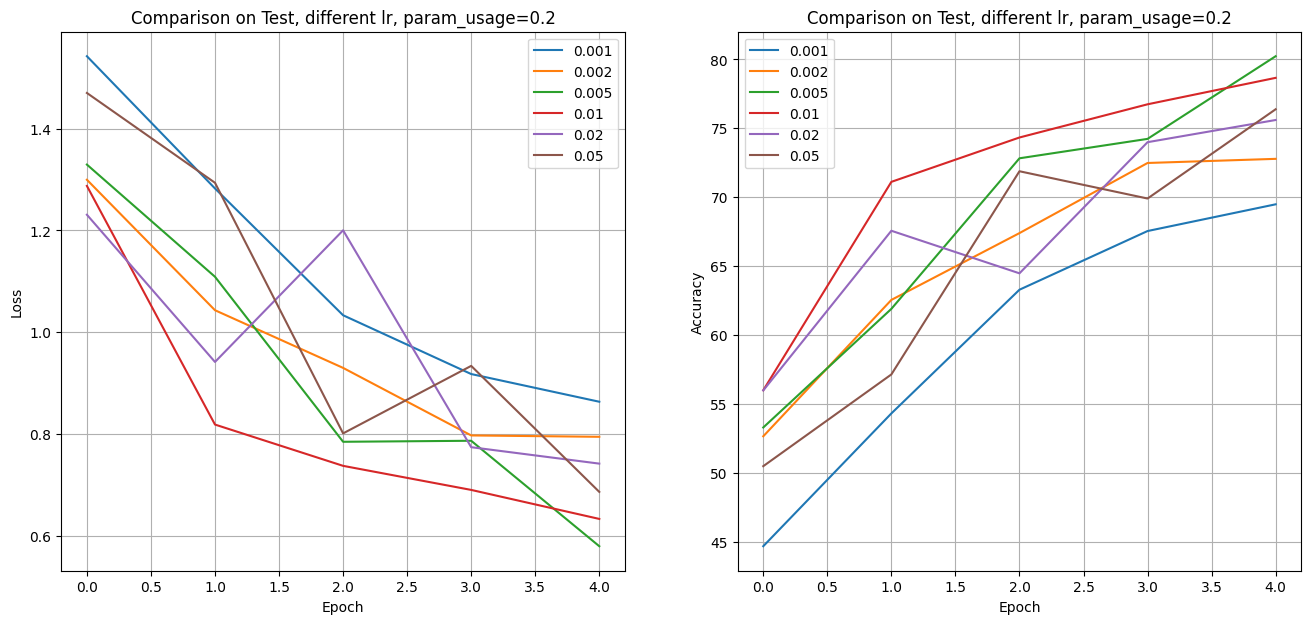

In [39]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for lr in test_log:
    axs[0].plot(test_log[lr], label=lr)
    axs[1].plot(test_acc[lr], label=lr)

axs[0].set_title("Comparison on Test, different lr, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different lr, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [22]:
param_usage = 0.2
num_epochs = 5
lrs = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

compression_type = 'square_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for lr in lrs:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[lr], train_acc[lr], test_log[lr], test_acc[lr] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.678 | Train Acc: 37.708% (18854/50000)


 20%|██        | 1/5 [00:19<01:16, 19.05s/it]

Validation Loss: 1.444 | Validation Acc: 46.240% (4624/10000)

Epoch: 1
Train Loss: 1.304 | Train Acc: 52.526% (26263/50000)


 40%|████      | 2/5 [00:37<00:55, 18.59s/it]

Validation Loss: 1.224 | Validation Acc: 55.020% (5502/10000)

Epoch: 2
Train Loss: 1.113 | Train Acc: 60.104% (30052/50000)


 60%|██████    | 3/5 [00:54<00:36, 18.17s/it]

Validation Loss: 1.033 | Validation Acc: 63.040% (6304/10000)

Epoch: 3
Train Loss: 0.978 | Train Acc: 65.150% (32575/50000)


 80%|████████  | 4/5 [01:13<00:18, 18.13s/it]

Validation Loss: 0.953 | Validation Acc: 65.630% (6563/10000)

Epoch: 4
Train Loss: 0.884 | Train Acc: 68.656% (34328/50000)


100%|██████████| 5/5 [01:30<00:00, 18.08s/it]


Validation Loss: 1.034 | Validation Acc: 64.310% (6431/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.565 | Train Acc: 42.014% (21007/50000)


 20%|██        | 1/5 [00:21<01:24, 21.23s/it]

Validation Loss: 1.341 | Validation Acc: 50.820% (5082/10000)

Epoch: 1
Train Loss: 1.131 | Train Acc: 59.418% (29709/50000)


 40%|████      | 2/5 [00:40<01:00, 20.14s/it]

Validation Loss: 1.014 | Validation Acc: 64.270% (6427/10000)

Epoch: 2
Train Loss: 0.933 | Train Acc: 66.842% (33421/50000)


 60%|██████    | 3/5 [01:00<00:40, 20.10s/it]

Validation Loss: 0.918 | Validation Acc: 68.120% (6812/10000)

Epoch: 3
Train Loss: 0.793 | Train Acc: 72.092% (36046/50000)


 80%|████████  | 4/5 [01:19<00:19, 19.77s/it]

Validation Loss: 0.760 | Validation Acc: 73.590% (7359/10000)

Epoch: 4
Train Loss: 0.692 | Train Acc: 75.778% (37889/50000)


100%|██████████| 5/5 [01:38<00:00, 19.67s/it]


Validation Loss: 0.743 | Validation Acc: 74.930% (7493/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.495 | Train Acc: 45.090% (22545/50000)


 20%|██        | 1/5 [00:18<01:13, 18.35s/it]

Validation Loss: 1.309 | Validation Acc: 53.650% (5365/10000)

Epoch: 1
Train Loss: 1.036 | Train Acc: 62.822% (31411/50000)


 40%|████      | 2/5 [00:39<00:59, 19.73s/it]

Validation Loss: 1.004 | Validation Acc: 64.240% (6424/10000)

Epoch: 2
Train Loss: 0.823 | Train Acc: 70.912% (35456/50000)


 60%|██████    | 3/5 [00:59<00:40, 20.07s/it]

Validation Loss: 0.781 | Validation Acc: 72.650% (7265/10000)

Epoch: 3
Train Loss: 0.680 | Train Acc: 75.918% (37959/50000)


 80%|████████  | 4/5 [01:17<00:19, 19.12s/it]

Validation Loss: 0.724 | Validation Acc: 75.260% (7526/10000)

Epoch: 4
Train Loss: 0.595 | Train Acc: 79.266% (39633/50000)


100%|██████████| 5/5 [01:34<00:00, 18.99s/it]


Validation Loss: 0.742 | Validation Acc: 75.320% (7532/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.509 | Train Acc: 44.744% (22372/50000)


 20%|██        | 1/5 [00:19<01:16, 19.11s/it]

Validation Loss: 1.323 | Validation Acc: 54.070% (5407/10000)

Epoch: 1
Train Loss: 1.043 | Train Acc: 62.922% (31461/50000)


 40%|████      | 2/5 [00:38<00:57, 19.10s/it]

Validation Loss: 1.259 | Validation Acc: 58.660% (5866/10000)

Epoch: 2
Train Loss: 0.808 | Train Acc: 71.530% (35765/50000)


 60%|██████    | 3/5 [01:01<00:41, 20.79s/it]

Validation Loss: 0.858 | Validation Acc: 71.880% (7188/10000)

Epoch: 3
Train Loss: 0.672 | Train Acc: 76.566% (38283/50000)


 80%|████████  | 4/5 [01:20<00:20, 20.21s/it]

Validation Loss: 0.771 | Validation Acc: 74.050% (7405/10000)

Epoch: 4
Train Loss: 0.578 | Train Acc: 79.838% (39919/50000)


100%|██████████| 5/5 [01:39<00:00, 19.93s/it]


Validation Loss: 0.662 | Validation Acc: 78.440% (7844/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.552 | Train Acc: 43.414% (21707/50000)


 20%|██        | 1/5 [00:18<01:12, 18.10s/it]

Validation Loss: 1.525 | Validation Acc: 48.370% (4837/10000)

Epoch: 1
Train Loss: 1.050 | Train Acc: 62.654% (31327/50000)


 40%|████      | 2/5 [00:37<00:56, 18.79s/it]

Validation Loss: 0.914 | Validation Acc: 68.330% (6833/10000)

Epoch: 2
Train Loss: 0.809 | Train Acc: 71.510% (35755/50000)


 60%|██████    | 3/5 [00:57<00:38, 19.19s/it]

Validation Loss: 0.717 | Validation Acc: 75.050% (7505/10000)

Epoch: 3
Train Loss: 0.671 | Train Acc: 76.640% (38320/50000)


 80%|████████  | 4/5 [01:15<00:19, 19.07s/it]

Validation Loss: 0.746 | Validation Acc: 74.080% (7408/10000)

Epoch: 4
Train Loss: 0.593 | Train Acc: 79.414% (39707/50000)


100%|██████████| 5/5 [01:34<00:00, 18.97s/it]


Validation Loss: 0.566 | Validation Acc: 80.480% (8048/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.753 | Train Acc: 36.846% (18423/50000)


 20%|██        | 1/5 [00:17<01:11, 17.83s/it]

Validation Loss: 1.384 | Validation Acc: 49.480% (4948/10000)

Epoch: 1
Train Loss: 1.265 | Train Acc: 54.066% (27033/50000)


 40%|████      | 2/5 [00:37<00:57, 19.09s/it]

Validation Loss: 1.146 | Validation Acc: 58.660% (5866/10000)

Epoch: 2
Train Loss: 1.004 | Train Acc: 64.332% (32166/50000)


 60%|██████    | 3/5 [00:56<00:37, 18.87s/it]

Validation Loss: 0.946 | Validation Acc: 66.880% (6688/10000)

Epoch: 3
Train Loss: 0.820 | Train Acc: 71.034% (35517/50000)


 80%|████████  | 4/5 [01:15<00:18, 18.80s/it]

Validation Loss: 1.037 | Validation Acc: 65.890% (6589/10000)

Epoch: 4
Train Loss: 0.708 | Train Acc: 75.336% (37668/50000)


100%|██████████| 5/5 [01:33<00:00, 18.60s/it]

Validation Loss: 0.693 | Validation Acc: 76.120% (7612/10000)


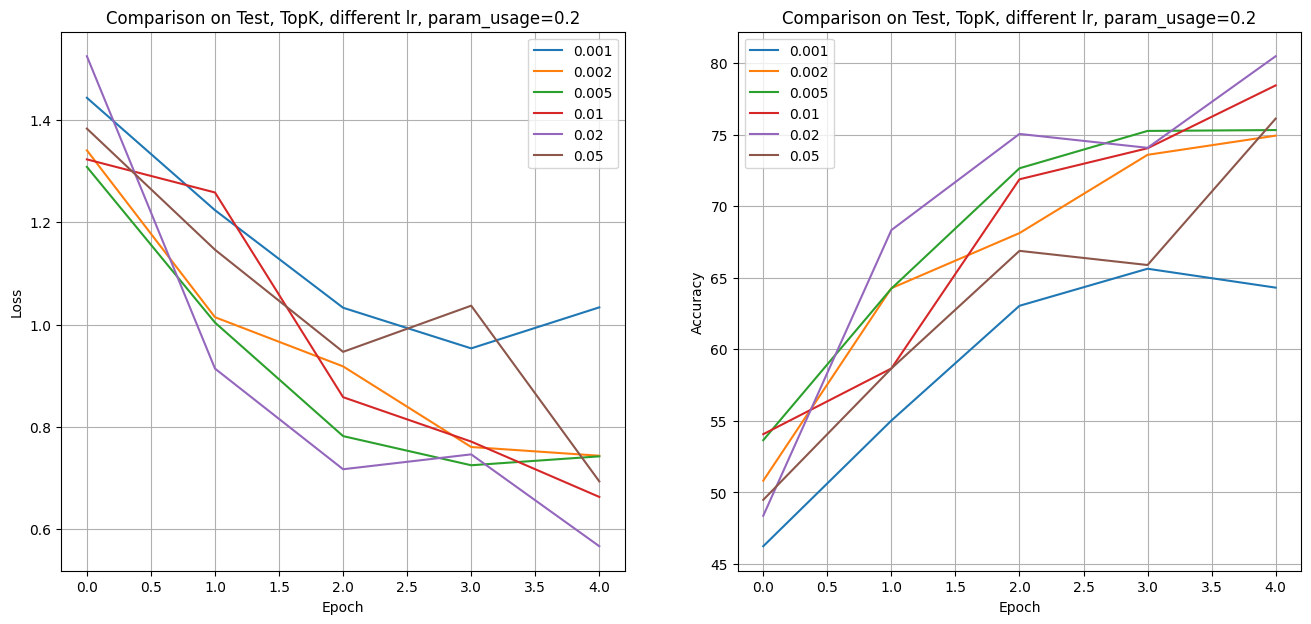

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for lr in test_log:
    axs[0].plot(test_log[lr], label=lr)
    axs[1].plot(test_acc[lr], label=lr)

axs[0].set_title("Comparison on Test, TopK, different lr, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, TopK, different lr, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [ ]:
param_usage = 0.2
num_epochs = 5
lrs = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

compression_type = 'mirror_descent_weighted_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for lr in lrs:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[lr], train_acc[lr], test_log[lr], test_acc[lr] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.687 | Train Acc: 37.466% (18733/50000)


 20%|██        | 1/5 [02:26<09:45, 146.41s/it]

Validation Loss: 1.483 | Validation Acc: 44.080% (4408/10000)

Epoch: 1
Train Loss: 1.303 | Train Acc: 52.322% (26161/50000)


 40%|████      | 2/5 [04:54<07:22, 147.44s/it]

Validation Loss: 1.255 | Validation Acc: 54.470% (5447/10000)

Epoch: 2
Train Loss: 1.103 | Train Acc: 60.230% (30115/50000)


 60%|██████    | 3/5 [07:22<04:55, 147.55s/it]

Validation Loss: 1.065 | Validation Acc: 62.020% (6202/10000)

Epoch: 3


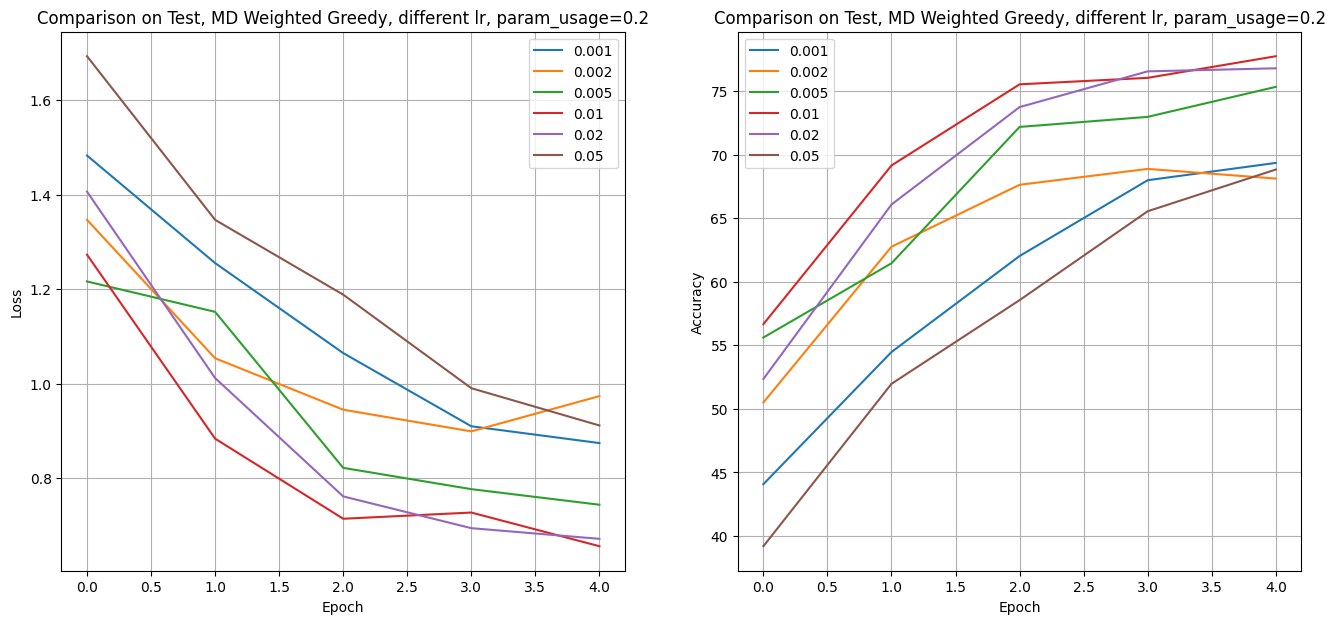

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for lr in test_log:
    axs[0].plot(test_log[lr], label=lr)
    axs[1].plot(test_acc[lr], label=lr)

axs[0].set_title("Comparison on Test, MD Weighted Greedy, different lr, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, MD Weighted Greedy, different lr, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [12]:
param_usage = 0.2
num_epochs = 5
lr = 0.01
num_steps_list = [1, 3, 5, 10, 20, 50]

compression_type = 'mirror_descent_weighted_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for num_steps in num_steps_list:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[num_steps], train_acc[num_steps], test_log[num_steps], test_acc[num_steps] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr, num_steps=num_steps)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.488 | Train Acc: 45.212% (22606/50000)


 20%|██        | 1/5 [00:22<01:30, 22.62s/it]

Validation Loss: 1.575 | Validation Acc: 50.320% (5032/10000)

Epoch: 1
Train Loss: 1.027 | Train Acc: 63.292% (31646/50000)


 40%|████      | 2/5 [00:45<01:08, 22.70s/it]

Validation Loss: 0.956 | Validation Acc: 66.710% (6671/10000)

Epoch: 2
Train Loss: 0.800 | Train Acc: 71.662% (35831/50000)


 60%|██████    | 3/5 [01:07<00:44, 22.50s/it]

Validation Loss: 0.774 | Validation Acc: 73.220% (7322/10000)

Epoch: 3
Train Loss: 0.674 | Train Acc: 76.344% (38172/50000)


 80%|████████  | 4/5 [01:31<00:22, 22.92s/it]

Validation Loss: 0.768 | Validation Acc: 74.480% (7448/10000)

Epoch: 4
Train Loss: 0.579 | Train Acc: 79.842% (39921/50000)


100%|██████████| 5/5 [01:53<00:00, 22.69s/it]


Validation Loss: 0.679 | Validation Acc: 76.880% (7688/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.483 | Train Acc: 45.590% (22795/50000)


 20%|██        | 1/5 [00:22<01:28, 22.16s/it]

Validation Loss: 1.320 | Validation Acc: 54.100% (5410/10000)

Epoch: 1
Train Loss: 1.015 | Train Acc: 63.862% (31931/50000)


 40%|████      | 2/5 [00:44<01:07, 22.38s/it]

Validation Loss: 1.147 | Validation Acc: 62.970% (6297/10000)

Epoch: 2
Train Loss: 0.786 | Train Acc: 72.556% (36278/50000)


 60%|██████    | 3/5 [01:09<00:47, 23.64s/it]

Validation Loss: 0.850 | Validation Acc: 71.840% (7184/10000)

Epoch: 3
Train Loss: 0.656 | Train Acc: 77.340% (38670/50000)


 80%|████████  | 4/5 [01:32<00:23, 23.14s/it]

Validation Loss: 0.595 | Validation Acc: 79.370% (7937/10000)

Epoch: 4
Train Loss: 0.562 | Train Acc: 80.586% (40293/50000)


100%|██████████| 5/5 [01:55<00:00, 23.13s/it]


Validation Loss: 0.686 | Validation Acc: 76.730% (7673/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.488 | Train Acc: 45.184% (22592/50000)


 20%|██        | 1/5 [00:24<01:37, 24.30s/it]

Validation Loss: 1.290 | Validation Acc: 55.510% (5551/10000)

Epoch: 1
Train Loss: 1.002 | Train Acc: 64.380% (32190/50000)


 40%|████      | 2/5 [00:48<01:13, 24.45s/it]

Validation Loss: 0.971 | Validation Acc: 67.500% (6750/10000)

Epoch: 2
Train Loss: 0.773 | Train Acc: 72.782% (36391/50000)


 60%|██████    | 3/5 [01:13<00:48, 24.39s/it]

Validation Loss: 0.855 | Validation Acc: 70.850% (7085/10000)

Epoch: 3
Train Loss: 0.646 | Train Acc: 77.548% (38774/50000)


 80%|████████  | 4/5 [01:37<00:24, 24.47s/it]

Validation Loss: 0.718 | Validation Acc: 76.340% (7634/10000)

Epoch: 4
Train Loss: 0.561 | Train Acc: 80.604% (40302/50000)


100%|██████████| 5/5 [02:03<00:00, 24.62s/it]


Validation Loss: 0.565 | Validation Acc: 81.210% (8121/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.491 | Train Acc: 45.090% (22545/50000)


 20%|██        | 1/5 [00:27<01:51, 27.77s/it]

Validation Loss: 1.349 | Validation Acc: 51.770% (5177/10000)

Epoch: 1
Train Loss: 1.004 | Train Acc: 64.238% (32119/50000)


 40%|████      | 2/5 [00:56<01:24, 28.15s/it]

Validation Loss: 1.016 | Validation Acc: 65.340% (6534/10000)

Epoch: 2
Train Loss: 0.779 | Train Acc: 72.586% (36293/50000)


 60%|██████    | 3/5 [01:24<00:56, 28.33s/it]

Validation Loss: 0.906 | Validation Acc: 70.180% (7018/10000)

Epoch: 3
Train Loss: 0.650 | Train Acc: 77.328% (38664/50000)


 80%|████████  | 4/5 [01:51<00:27, 27.85s/it]

Validation Loss: 0.773 | Validation Acc: 74.280% (7428/10000)

Epoch: 4
Train Loss: 0.574 | Train Acc: 80.088% (40044/50000)


100%|██████████| 5/5 [02:18<00:00, 27.66s/it]


Validation Loss: 0.699 | Validation Acc: 76.350% (7635/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.481 | Train Acc: 45.900% (22950/50000)


 20%|██        | 1/5 [00:34<02:16, 34.08s/it]

Validation Loss: 1.469 | Validation Acc: 51.290% (5129/10000)

Epoch: 1
Train Loss: 0.998 | Train Acc: 64.696% (32348/50000)


 40%|████      | 2/5 [01:07<01:41, 33.77s/it]

Validation Loss: 0.939 | Validation Acc: 66.510% (6651/10000)

Epoch: 2
Train Loss: 0.777 | Train Acc: 72.678% (36339/50000)


 60%|██████    | 3/5 [01:42<01:08, 34.13s/it]

Validation Loss: 0.756 | Validation Acc: 74.270% (7427/10000)

Epoch: 3
Train Loss: 0.647 | Train Acc: 77.354% (38677/50000)


 80%|████████  | 4/5 [02:16<00:34, 34.02s/it]

Validation Loss: 0.753 | Validation Acc: 75.410% (7541/10000)

Epoch: 4
Train Loss: 0.570 | Train Acc: 80.192% (40096/50000)


100%|██████████| 5/5 [02:51<00:00, 34.22s/it]


Validation Loss: 0.546 | Validation Acc: 81.470% (8147/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.505 | Train Acc: 44.910% (22455/50000)


 20%|██        | 1/5 [00:52<03:30, 52.73s/it]

Validation Loss: 1.225 | Validation Acc: 58.030% (5803/10000)

Epoch: 1
Train Loss: 1.014 | Train Acc: 63.974% (31987/50000)


 40%|████      | 2/5 [01:45<02:37, 52.52s/it]

Validation Loss: 1.102 | Validation Acc: 62.740% (6274/10000)

Epoch: 2
Train Loss: 0.787 | Train Acc: 72.178% (36089/50000)


 60%|██████    | 3/5 [02:37<01:44, 52.48s/it]

Validation Loss: 0.787 | Validation Acc: 72.240% (7224/10000)

Epoch: 3
Train Loss: 0.651 | Train Acc: 77.356% (38678/50000)


 80%|████████  | 4/5 [03:30<00:52, 52.72s/it]

Validation Loss: 1.033 | Validation Acc: 67.390% (6739/10000)

Epoch: 4
Train Loss: 0.576 | Train Acc: 80.028% (40014/50000)


100%|██████████| 5/5 [04:23<00:00, 52.77s/it]

Validation Loss: 0.574 | Validation Acc: 80.290% (8029/10000)


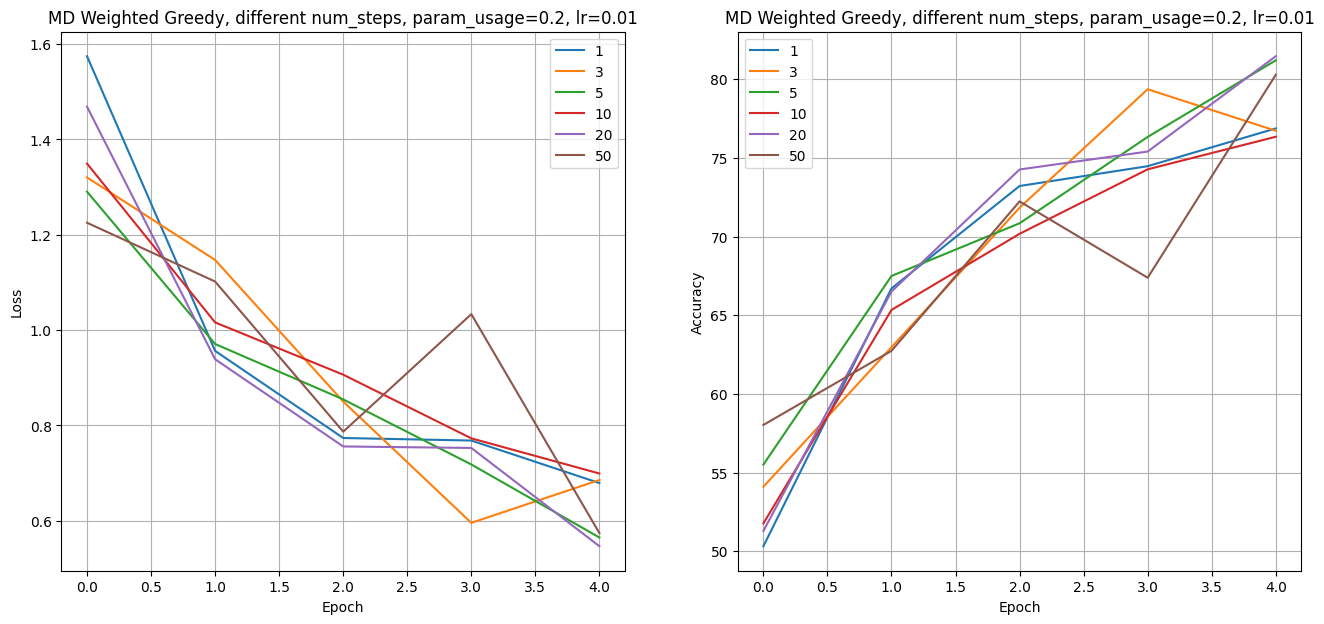

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for num_steps in test_log:
    axs[0].plot(test_log[num_steps], label=num_steps)
    axs[1].plot(test_acc[num_steps], label=num_steps)

axs[0].set_title("MD Weighted Greedy, different num_steps, param_usage=0.2, lr=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("MD Weighted Greedy, different num_steps, param_usage=0.2, lr=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [9]:
param_usage = 0.2
num_epochs = 5
lr = 0.01
num_steps_list = [1, 3, 5, 10, 20, 50]

compression_type = 'gradient_descent_weighted_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for num_steps in num_steps_list:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[num_steps], train_acc[num_steps], test_log[num_steps], test_acc[num_steps] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr, num_steps=num_steps)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.485 | Train Acc: 45.432% (22716/50000)


 20%|██        | 1/5 [00:23<01:32, 23.14s/it]

Validation Loss: 1.316 | Validation Acc: 53.120% (5312/10000)

Epoch: 1
Train Loss: 1.055 | Train Acc: 62.176% (31088/50000)


 40%|████      | 2/5 [00:44<01:06, 22.18s/it]

Validation Loss: 1.015 | Validation Acc: 65.260% (6526/10000)

Epoch: 2
Train Loss: 0.848 | Train Acc: 69.880% (34940/50000)


 60%|██████    | 3/5 [01:05<00:43, 21.61s/it]

Validation Loss: 1.084 | Validation Acc: 64.790% (6479/10000)

Epoch: 3
Train Loss: 0.705 | Train Acc: 75.356% (37678/50000)


 80%|████████  | 4/5 [01:28<00:22, 22.17s/it]

Validation Loss: 0.768 | Validation Acc: 74.590% (7459/10000)

Epoch: 4
Train Loss: 0.625 | Train Acc: 78.222% (39111/50000)


100%|██████████| 5/5 [01:49<00:00, 21.93s/it]


Validation Loss: 0.635 | Validation Acc: 78.420% (7842/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.504 | Train Acc: 44.584% (22292/50000)


 20%|██        | 1/5 [00:20<01:22, 20.61s/it]

Validation Loss: 1.271 | Validation Acc: 54.320% (5432/10000)

Epoch: 1
Train Loss: 1.062 | Train Acc: 62.076% (31038/50000)


 40%|████      | 2/5 [00:42<01:04, 21.42s/it]

Validation Loss: 1.171 | Validation Acc: 60.320% (6032/10000)

Epoch: 2
Train Loss: 0.840 | Train Acc: 70.430% (35215/50000)


 60%|██████    | 3/5 [01:06<00:45, 22.72s/it]

Validation Loss: 0.882 | Validation Acc: 69.380% (6938/10000)

Epoch: 3
Train Loss: 0.705 | Train Acc: 75.388% (37694/50000)


 80%|████████  | 4/5 [01:28<00:22, 22.28s/it]

Validation Loss: 0.775 | Validation Acc: 73.160% (7316/10000)

Epoch: 4
Train Loss: 0.609 | Train Acc: 78.794% (39397/50000)


100%|██████████| 5/5 [01:50<00:00, 22.04s/it]


Validation Loss: 0.667 | Validation Acc: 77.480% (7748/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.501 | Train Acc: 44.706% (22353/50000)


 20%|██        | 1/5 [00:21<01:27, 21.89s/it]

Validation Loss: 1.249 | Validation Acc: 55.100% (5510/10000)

Epoch: 1
Train Loss: 1.060 | Train Acc: 61.964% (30982/50000)


 40%|████      | 2/5 [00:44<01:07, 22.51s/it]

Validation Loss: 0.952 | Validation Acc: 66.260% (6626/10000)

Epoch: 2
Train Loss: 0.839 | Train Acc: 70.192% (35096/50000)


 60%|██████    | 3/5 [01:08<00:46, 23.26s/it]

Validation Loss: 0.835 | Validation Acc: 71.130% (7113/10000)

Epoch: 3
Train Loss: 0.698 | Train Acc: 75.498% (37749/50000)


 80%|████████  | 4/5 [01:31<00:22, 22.90s/it]

Validation Loss: 0.798 | Validation Acc: 73.260% (7326/10000)

Epoch: 4
Train Loss: 0.608 | Train Acc: 78.780% (39390/50000)


100%|██████████| 5/5 [01:54<00:00, 22.91s/it]


Validation Loss: 0.589 | Validation Acc: 80.310% (8031/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.475 | Train Acc: 45.664% (22832/50000)


 20%|██        | 1/5 [00:27<01:50, 27.50s/it]

Validation Loss: 1.478 | Validation Acc: 48.920% (4892/10000)

Epoch: 1
Train Loss: 1.029 | Train Acc: 63.242% (31621/50000)


 40%|████      | 2/5 [00:54<01:21, 27.31s/it]

Validation Loss: 1.273 | Validation Acc: 58.260% (5826/10000)

Epoch: 2
Train Loss: 0.814 | Train Acc: 71.150% (35575/50000)


 60%|██████    | 3/5 [01:21<00:54, 27.11s/it]

Validation Loss: 0.795 | Validation Acc: 73.110% (7311/10000)

Epoch: 3
Train Loss: 0.686 | Train Acc: 76.056% (38028/50000)


 80%|████████  | 4/5 [01:47<00:26, 26.78s/it]

Validation Loss: 0.855 | Validation Acc: 72.110% (7211/10000)

Epoch: 4
Train Loss: 0.603 | Train Acc: 78.882% (39441/50000)


100%|██████████| 5/5 [02:14<00:00, 26.84s/it]


Validation Loss: 0.670 | Validation Acc: 77.510% (7751/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.525 | Train Acc: 43.610% (21805/50000)


 20%|██        | 1/5 [00:33<02:12, 33.18s/it]

Validation Loss: 1.217 | Validation Acc: 56.040% (5604/10000)

Epoch: 1
Train Loss: 1.063 | Train Acc: 61.818% (30909/50000)


 40%|████      | 2/5 [01:07<01:40, 33.60s/it]

Validation Loss: 1.010 | Validation Acc: 65.200% (6520/10000)

Epoch: 2
Train Loss: 0.842 | Train Acc: 70.292% (35146/50000)


 60%|██████    | 3/5 [01:39<01:06, 33.23s/it]

Validation Loss: 0.974 | Validation Acc: 67.890% (6789/10000)

Epoch: 3
Train Loss: 0.708 | Train Acc: 75.186% (37593/50000)


 80%|████████  | 4/5 [02:13<00:33, 33.54s/it]

Validation Loss: 0.704 | Validation Acc: 76.350% (7635/10000)

Epoch: 4
Train Loss: 0.612 | Train Acc: 78.594% (39297/50000)


100%|██████████| 5/5 [02:47<00:00, 33.43s/it]


Validation Loss: 0.663 | Validation Acc: 77.900% (7790/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.497 | Train Acc: 45.014% (22507/50000)


 20%|██        | 1/5 [00:51<03:26, 51.71s/it]

Validation Loss: 1.341 | Validation Acc: 52.360% (5236/10000)

Epoch: 1
Train Loss: 1.050 | Train Acc: 62.482% (31241/50000)


 40%|████      | 2/5 [01:42<02:33, 51.02s/it]

Validation Loss: 1.095 | Validation Acc: 62.300% (6230/10000)

Epoch: 2
Train Loss: 0.819 | Train Acc: 71.228% (35614/50000)


 60%|██████    | 3/5 [02:32<01:40, 50.49s/it]

Validation Loss: 0.899 | Validation Acc: 68.970% (6897/10000)

Epoch: 3
Train Loss: 0.688 | Train Acc: 75.988% (37994/50000)


 80%|████████  | 4/5 [03:23<00:51, 51.02s/it]

Validation Loss: 0.899 | Validation Acc: 69.280% (6928/10000)

Epoch: 4
Train Loss: 0.608 | Train Acc: 78.792% (39396/50000)


100%|██████████| 5/5 [04:16<00:00, 51.37s/it]

Validation Loss: 0.674 | Validation Acc: 77.150% (7715/10000)


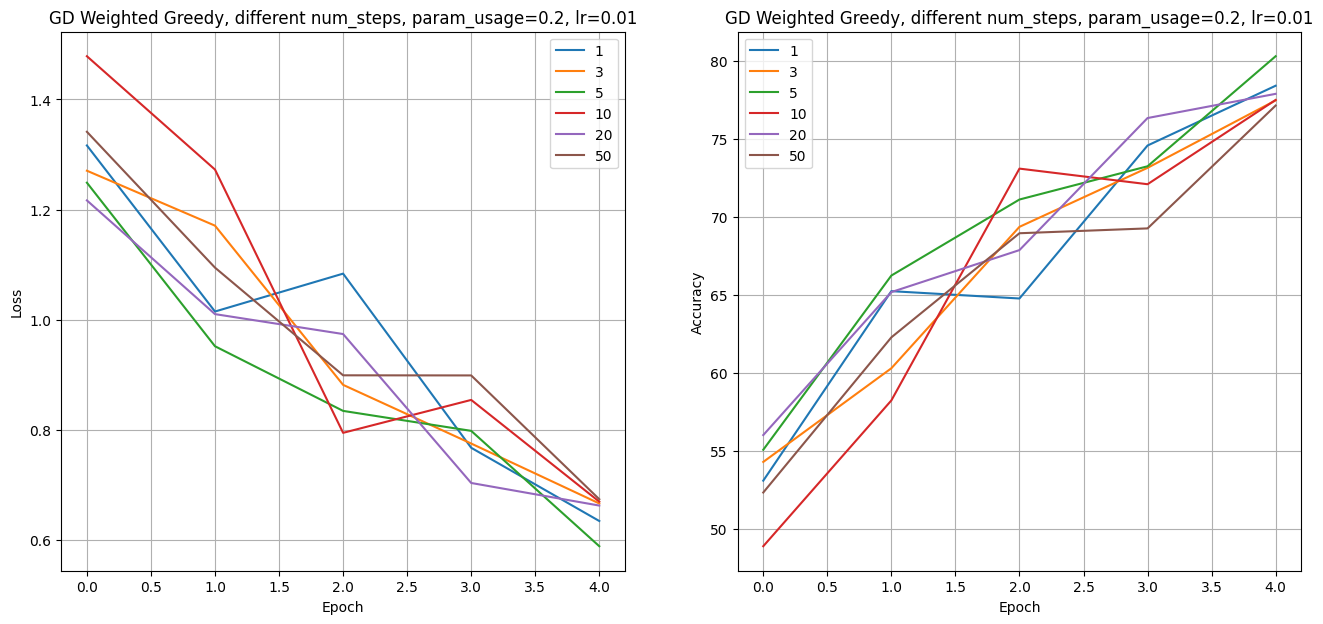

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for num_steps in test_log:
    axs[0].plot(test_log[num_steps], label=num_steps)
    axs[1].plot(test_acc[num_steps], label=num_steps)

axs[0].set_title("GD Weighted Greedy, different num_steps, param_usage=0.2, lr=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("GD Weighted Greedy, different num_steps, param_usage=0.2, lr=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [14]:
param_usage = 1.0
num_epochs = 5
lr = 0.01
num_steps_list = [1, 3, 5, 10, 20, 50]

compression_type = 'gradient_descent_weighted_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for num_steps in num_steps_list:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[num_steps], train_acc[num_steps], test_log[num_steps], test_acc[num_steps] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr, num_steps=num_steps)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.414 | Train Acc: 48.058% (24029/50000)


 20%|██        | 1/5 [00:21<01:24, 21.07s/it]

Validation Loss: 1.134 | Validation Acc: 60.120% (6012/10000)

Epoch: 1
Train Loss: 0.922 | Train Acc: 67.200% (33600/50000)


 40%|████      | 2/5 [00:40<01:00, 20.19s/it]

Validation Loss: 1.028 | Validation Acc: 66.130% (6613/10000)

Epoch: 2
Train Loss: 0.714 | Train Acc: 74.914% (37457/50000)


 60%|██████    | 3/5 [01:00<00:40, 20.13s/it]

Validation Loss: 0.685 | Validation Acc: 77.020% (7702/10000)

Epoch: 3
Train Loss: 0.606 | Train Acc: 78.858% (39429/50000)


 80%|████████  | 4/5 [01:21<00:20, 20.54s/it]

Validation Loss: 0.751 | Validation Acc: 75.560% (7556/10000)

Epoch: 4
Train Loss: 0.530 | Train Acc: 81.736% (40868/50000)


100%|██████████| 5/5 [01:42<00:00, 20.51s/it]


Validation Loss: 0.577 | Validation Acc: 80.640% (8064/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.435 | Train Acc: 47.392% (23696/50000)


 20%|██        | 1/5 [00:21<01:27, 21.90s/it]

Validation Loss: 1.155 | Validation Acc: 59.370% (5937/10000)

Epoch: 1
Train Loss: 0.955 | Train Acc: 65.942% (32971/50000)


 40%|████      | 2/5 [00:44<01:06, 22.21s/it]

Validation Loss: 0.970 | Validation Acc: 68.010% (6801/10000)

Epoch: 2
Train Loss: 0.725 | Train Acc: 74.558% (37279/50000)


 60%|██████    | 3/5 [01:06<00:44, 22.40s/it]

Validation Loss: 0.726 | Validation Acc: 75.250% (7525/10000)

Epoch: 3
Train Loss: 0.609 | Train Acc: 78.728% (39364/50000)


 80%|████████  | 4/5 [01:28<00:22, 22.03s/it]

Validation Loss: 0.697 | Validation Acc: 76.900% (7690/10000)

Epoch: 4
Train Loss: 0.542 | Train Acc: 81.008% (40504/50000)


100%|██████████| 5/5 [01:49<00:00, 21.86s/it]


Validation Loss: 0.637 | Validation Acc: 78.490% (7849/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.415 | Train Acc: 48.370% (24185/50000)


 20%|██        | 1/5 [00:22<01:30, 22.63s/it]

Validation Loss: 1.175 | Validation Acc: 57.930% (5793/10000)

Epoch: 1
Train Loss: 0.921 | Train Acc: 67.312% (33656/50000)


 40%|████      | 2/5 [00:45<01:08, 22.71s/it]

Validation Loss: 1.089 | Validation Acc: 65.360% (6536/10000)

Epoch: 2
Train Loss: 0.720 | Train Acc: 74.756% (37378/50000)


 60%|██████    | 3/5 [01:09<00:46, 23.33s/it]

Validation Loss: 0.821 | Validation Acc: 72.660% (7266/10000)

Epoch: 3
Train Loss: 0.606 | Train Acc: 78.814% (39407/50000)


 80%|████████  | 4/5 [01:33<00:23, 23.72s/it]

Validation Loss: 0.672 | Validation Acc: 77.530% (7753/10000)

Epoch: 4
Train Loss: 0.534 | Train Acc: 81.562% (40781/50000)


100%|██████████| 5/5 [01:57<00:00, 23.41s/it]


Validation Loss: 0.555 | Validation Acc: 81.270% (8127/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.463 | Train Acc: 46.418% (23209/50000)


 20%|██        | 1/5 [00:24<01:37, 24.49s/it]

Validation Loss: 1.255 | Validation Acc: 56.350% (5635/10000)

Epoch: 1
Train Loss: 0.947 | Train Acc: 66.396% (33198/50000)


 40%|████      | 2/5 [00:51<01:18, 26.18s/it]

Validation Loss: 1.030 | Validation Acc: 66.030% (6603/10000)

Epoch: 2
Train Loss: 0.737 | Train Acc: 74.126% (37063/50000)


 60%|██████    | 3/5 [01:18<00:52, 26.38s/it]

Validation Loss: 0.701 | Validation Acc: 75.940% (7594/10000)

Epoch: 3
Train Loss: 0.616 | Train Acc: 78.508% (39254/50000)


 80%|████████  | 4/5 [01:43<00:25, 25.97s/it]

Validation Loss: 0.648 | Validation Acc: 78.010% (7801/10000)

Epoch: 4
Train Loss: 0.537 | Train Acc: 81.352% (40676/50000)


100%|██████████| 5/5 [02:10<00:00, 26.12s/it]


Validation Loss: 0.609 | Validation Acc: 79.070% (7907/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.436 | Train Acc: 47.436% (23718/50000)


 20%|██        | 1/5 [00:33<02:14, 33.69s/it]

Validation Loss: 1.442 | Validation Acc: 53.070% (5307/10000)

Epoch: 1
Train Loss: 0.938 | Train Acc: 66.844% (33422/50000)


 40%|████      | 2/5 [01:06<01:40, 33.34s/it]

Validation Loss: 0.882 | Validation Acc: 69.590% (6959/10000)

Epoch: 2
Train Loss: 0.728 | Train Acc: 74.470% (37235/50000)


 60%|██████    | 3/5 [01:38<01:05, 32.51s/it]

Validation Loss: 0.747 | Validation Acc: 75.240% (7524/10000)

Epoch: 3
Train Loss: 0.615 | Train Acc: 78.544% (39272/50000)


 80%|████████  | 4/5 [02:13<00:33, 33.40s/it]

Validation Loss: 0.759 | Validation Acc: 75.310% (7531/10000)

Epoch: 4
Train Loss: 0.543 | Train Acc: 81.174% (40587/50000)


100%|██████████| 5/5 [02:46<00:00, 33.27s/it]


Validation Loss: 0.664 | Validation Acc: 77.670% (7767/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.468 | Train Acc: 46.236% (23118/50000)


 20%|██        | 1/5 [00:51<03:24, 51.22s/it]

Validation Loss: 1.379 | Validation Acc: 53.500% (5350/10000)

Epoch: 1
Train Loss: 0.978 | Train Acc: 64.940% (32470/50000)


 40%|████      | 2/5 [01:42<02:34, 51.50s/it]

Validation Loss: 0.957 | Validation Acc: 66.340% (6634/10000)

Epoch: 2
Train Loss: 0.757 | Train Acc: 73.480% (36740/50000)


 60%|██████    | 3/5 [02:35<01:43, 51.85s/it]

Validation Loss: 1.105 | Validation Acc: 66.400% (6640/10000)

Epoch: 3
Train Loss: 0.637 | Train Acc: 77.876% (38938/50000)


 80%|████████  | 4/5 [03:27<00:51, 51.86s/it]

Validation Loss: 0.738 | Validation Acc: 75.520% (7552/10000)

Epoch: 4
Train Loss: 0.554 | Train Acc: 80.666% (40333/50000)


100%|██████████| 5/5 [04:18<00:00, 51.64s/it]

Validation Loss: 0.581 | Validation Acc: 80.380% (8038/10000)


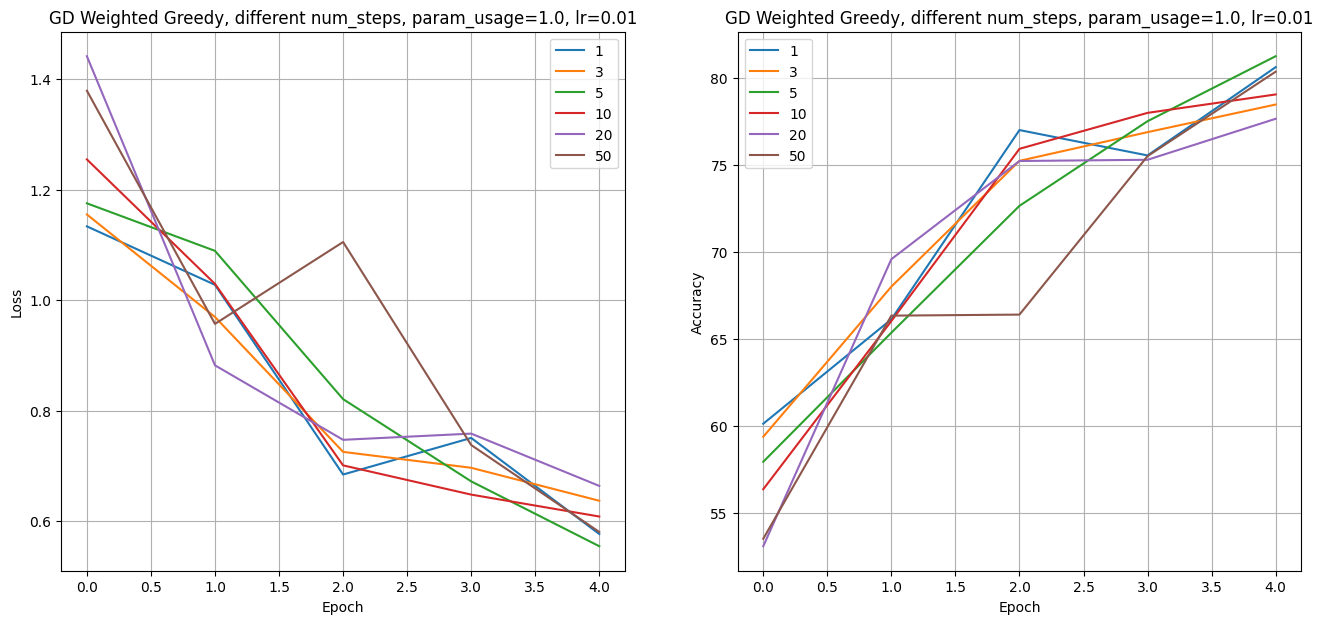

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for num_steps in test_log:
    axs[0].plot(test_log[num_steps], label=num_steps)
    axs[1].plot(test_acc[num_steps], label=num_steps)

axs[0].set_title("GD Weighted Greedy, different num_steps, param_usage=1.0, lr=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("GD Weighted Greedy, different num_steps, param_usage=1.0, lr=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [40]:
compression_types = ['gradient_descent_weighted_greedy', 'mirror_descent_weighted_greedy', 'square_greedy']
param_usage = 0.2
num_epochs = 15
lr = 0.01

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for compression_type in compression_types:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[compression_type], train_acc[compression_type], test_log[compression_type], test_acc[compression_type] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr)

  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.469 | Train Acc: 45.954% (22977/50000)


  7%|▋         | 1/15 [01:18<18:17, 78.40s/it]

Validation Loss: 1.210 | Validation Acc: 58.020% (5802/10000)

Epoch: 1
Train Loss: 1.000 | Train Acc: 64.398% (32199/50000)


 13%|█▎        | 2/15 [02:37<17:05, 78.85s/it]

Validation Loss: 1.084 | Validation Acc: 63.880% (6388/10000)

Epoch: 2
Train Loss: 0.791 | Train Acc: 71.994% (35997/50000)


 20%|██        | 3/15 [03:56<15:47, 78.97s/it]

Validation Loss: 0.815 | Validation Acc: 72.340% (7234/10000)

Epoch: 3
Train Loss: 0.664 | Train Acc: 76.614% (38307/50000)


 27%|██▋       | 4/15 [05:15<14:29, 79.06s/it]

Validation Loss: 0.643 | Validation Acc: 77.670% (7767/10000)

Epoch: 4
Train Loss: 0.510 | Train Acc: 82.322% (41161/50000)


 40%|████      | 6/15 [07:55<11:56, 79.61s/it]

Validation Loss: 0.653 | Validation Acc: 78.090% (7809/10000)

Epoch: 6
Train Loss: 0.469 | Train Acc: 83.768% (41884/50000)


 47%|████▋     | 7/15 [09:13<10:32, 79.00s/it]

Validation Loss: 0.550 | Validation Acc: 81.700% (8170/10000)

Epoch: 7
Train Loss: 0.427 | Train Acc: 85.364% (42682/50000)


 53%|█████▎    | 8/15 [10:33<09:13, 79.08s/it]

Validation Loss: 0.516 | Validation Acc: 83.260% (8326/10000)

Epoch: 8
Train Loss: 0.396 | Train Acc: 86.248% (43124/50000)


 60%|██████    | 9/15 [11:50<07:50, 78.48s/it]

Validation Loss: 0.455 | Validation Acc: 84.710% (8471/10000)

Epoch: 9
Train Loss: 0.368 | Train Acc: 87.246% (43623/50000)


 67%|██████▋   | 10/15 [13:09<06:33, 78.64s/it]

Validation Loss: 0.515 | Validation Acc: 83.060% (8306/10000)

Epoch: 10
Train Loss: 0.342 | Train Acc: 88.038% (44019/50000)


 73%|███████▎  | 11/15 [14:27<05:13, 78.43s/it]

Validation Loss: 0.471 | Validation Acc: 84.340% (8434/10000)

Epoch: 11
Train Loss: 0.320 | Train Acc: 88.822% (44411/50000)


 80%|████████  | 12/15 [15:47<03:56, 78.89s/it]

Validation Loss: 0.515 | Validation Acc: 83.800% (8380/10000)

Epoch: 12
Train Loss: 0.304 | Train Acc: 89.366% (44683/50000)


 87%|████████▋ | 13/15 [17:06<02:38, 79.17s/it]

Validation Loss: 0.412 | Validation Acc: 86.460% (8646/10000)

Epoch: 13
Train Loss: 0.279 | Train Acc: 90.184% (45092/50000)


 93%|█████████▎| 14/15 [18:25<01:18, 78.93s/it]

Validation Loss: 0.395 | Validation Acc: 86.800% (8680/10000)

Epoch: 14
Train Loss: 0.268 | Train Acc: 90.606% (45303/50000)


100%|██████████| 15/15 [19:43<00:00, 78.91s/it]


Validation Loss: 0.469 | Validation Acc: 85.070% (8507/10000)


  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.496 | Train Acc: 45.118% (22559/50000)


  7%|▋         | 1/15 [01:19<18:32, 79.44s/it]

Validation Loss: 1.356 | Validation Acc: 53.320% (5332/10000)

Epoch: 1
Train Loss: 1.032 | Train Acc: 63.334% (31667/50000)


 13%|█▎        | 2/15 [02:40<17:27, 80.55s/it]

Validation Loss: 1.012 | Validation Acc: 65.430% (6543/10000)

Epoch: 2
Train Loss: 0.804 | Train Acc: 71.928% (35964/50000)


 20%|██        | 3/15 [04:07<16:37, 83.15s/it]

Validation Loss: 0.770 | Validation Acc: 73.290% (7329/10000)

Epoch: 3
Train Loss: 0.672 | Train Acc: 76.604% (38302/50000)


 27%|██▋       | 4/15 [05:30<15:14, 83.12s/it]

Validation Loss: 0.799 | Validation Acc: 73.160% (7316/10000)

Epoch: 4
Train Loss: 0.582 | Train Acc: 79.870% (39935/50000)


 33%|███▎      | 5/15 [06:52<13:47, 82.71s/it]

Validation Loss: 0.617 | Validation Acc: 79.480% (7948/10000)

Epoch: 5
Train Loss: 0.517 | Train Acc: 82.004% (41002/50000)


 40%|████      | 6/15 [08:12<12:18, 82.05s/it]

Validation Loss: 0.552 | Validation Acc: 81.310% (8131/10000)

Epoch: 6
Train Loss: 0.467 | Train Acc: 83.844% (41922/50000)


 47%|████▋     | 7/15 [09:33<10:52, 81.62s/it]

Validation Loss: 0.614 | Validation Acc: 79.570% (7957/10000)

Epoch: 7
Train Loss: 0.435 | Train Acc: 84.906% (42453/50000)


 53%|█████▎    | 8/15 [10:56<09:35, 82.19s/it]

Validation Loss: 0.536 | Validation Acc: 82.210% (8221/10000)

Epoch: 8
Train Loss: 0.398 | Train Acc: 86.322% (43161/50000)


 60%|██████    | 9/15 [12:17<08:10, 81.73s/it]

Validation Loss: 0.523 | Validation Acc: 82.410% (8241/10000)

Epoch: 9
Train Loss: 0.369 | Train Acc: 87.104% (43552/50000)


 67%|██████▋   | 10/15 [13:38<06:46, 81.35s/it]

Validation Loss: 0.523 | Validation Acc: 82.960% (8296/10000)

Epoch: 10
Train Loss: 0.340 | Train Acc: 88.200% (44100/50000)


 73%|███████▎  | 11/15 [15:01<05:28, 82.03s/it]

Validation Loss: 0.406 | Validation Acc: 86.480% (8648/10000)

Epoch: 11
Train Loss: 0.319 | Train Acc: 88.978% (44489/50000)


 80%|████████  | 12/15 [16:25<04:07, 82.40s/it]

Validation Loss: 0.395 | Validation Acc: 86.720% (8672/10000)

Epoch: 12
Train Loss: 0.300 | Train Acc: 89.592% (44796/50000)


 87%|████████▋ | 13/15 [17:43<02:42, 81.12s/it]

Validation Loss: 0.452 | Validation Acc: 84.660% (8466/10000)

Epoch: 13
Train Loss: 0.284 | Train Acc: 90.256% (45128/50000)


 93%|█████████▎| 14/15 [19:09<01:22, 82.68s/it]

Validation Loss: 0.454 | Validation Acc: 85.250% (8525/10000)

Epoch: 14
Train Loss: 0.270 | Train Acc: 90.600% (45300/50000)


100%|██████████| 15/15 [20:37<00:00, 82.49s/it]


Validation Loss: 0.371 | Validation Acc: 87.720% (8772/10000)


  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.480 | Train Acc: 45.472% (22736/50000)


  7%|▋         | 1/15 [00:19<04:33, 19.50s/it]

Validation Loss: 1.300 | Validation Acc: 54.850% (5485/10000)

Epoch: 1
Train Loss: 1.003 | Train Acc: 64.246% (32123/50000)


 13%|█▎        | 2/15 [00:37<04:05, 18.89s/it]

Validation Loss: 0.849 | Validation Acc: 70.330% (7033/10000)

Epoch: 2
Train Loss: 0.776 | Train Acc: 72.806% (36403/50000)


 20%|██        | 3/15 [00:57<03:47, 18.98s/it]

Validation Loss: 0.869 | Validation Acc: 70.250% (7025/10000)

Epoch: 3
Train Loss: 0.652 | Train Acc: 77.094% (38547/50000)


 27%|██▋       | 4/15 [01:15<03:25, 18.72s/it]

Validation Loss: 0.646 | Validation Acc: 77.840% (7784/10000)

Epoch: 4
Train Loss: 0.564 | Train Acc: 80.340% (40170/50000)


 33%|███▎      | 5/15 [01:34<03:10, 19.01s/it]

Validation Loss: 0.621 | Validation Acc: 78.820% (7882/10000)

Epoch: 5
Train Loss: 0.507 | Train Acc: 82.480% (41240/50000)


 40%|████      | 6/15 [01:54<02:52, 19.11s/it]

Validation Loss: 0.583 | Validation Acc: 80.210% (8021/10000)

Epoch: 6
Train Loss: 0.457 | Train Acc: 84.108% (42054/50000)


 47%|████▋     | 7/15 [02:15<02:39, 19.92s/it]

Validation Loss: 0.577 | Validation Acc: 80.770% (8077/10000)

Epoch: 7
Train Loss: 0.420 | Train Acc: 85.552% (42776/50000)


 53%|█████▎    | 8/15 [02:34<02:16, 19.56s/it]

Validation Loss: 0.523 | Validation Acc: 82.090% (8209/10000)

Epoch: 8
Train Loss: 0.393 | Train Acc: 86.442% (43221/50000)


 60%|██████    | 9/15 [02:53<01:55, 19.22s/it]

Validation Loss: 0.429 | Validation Acc: 85.100% (8510/10000)

Epoch: 9
Train Loss: 0.362 | Train Acc: 87.442% (43721/50000)


 67%|██████▋   | 10/15 [03:12<01:36, 19.32s/it]

Validation Loss: 0.485 | Validation Acc: 84.010% (8401/10000)

Epoch: 10
Train Loss: 0.334 | Train Acc: 88.442% (44221/50000)


 73%|███████▎  | 11/15 [03:30<01:15, 18.99s/it]

Validation Loss: 0.450 | Validation Acc: 85.220% (8522/10000)

Epoch: 11
Train Loss: 0.318 | Train Acc: 88.814% (44407/50000)


 80%|████████  | 12/15 [03:50<00:57, 19.20s/it]

Validation Loss: 0.490 | Validation Acc: 83.640% (8364/10000)

Epoch: 12
Train Loss: 0.300 | Train Acc: 89.734% (44867/50000)


 87%|████████▋ | 13/15 [04:10<00:38, 19.31s/it]

Validation Loss: 0.400 | Validation Acc: 86.600% (8660/10000)

Epoch: 13
Train Loss: 0.279 | Train Acc: 90.278% (45139/50000)


 93%|█████████▎| 14/15 [04:31<00:20, 20.03s/it]

Validation Loss: 0.380 | Validation Acc: 87.540% (8754/10000)

Epoch: 14
Train Loss: 0.268 | Train Acc: 90.702% (45351/50000)


100%|██████████| 15/15 [04:49<00:00, 19.30s/it]

Validation Loss: 0.429 | Validation Acc: 85.510% (8551/10000)


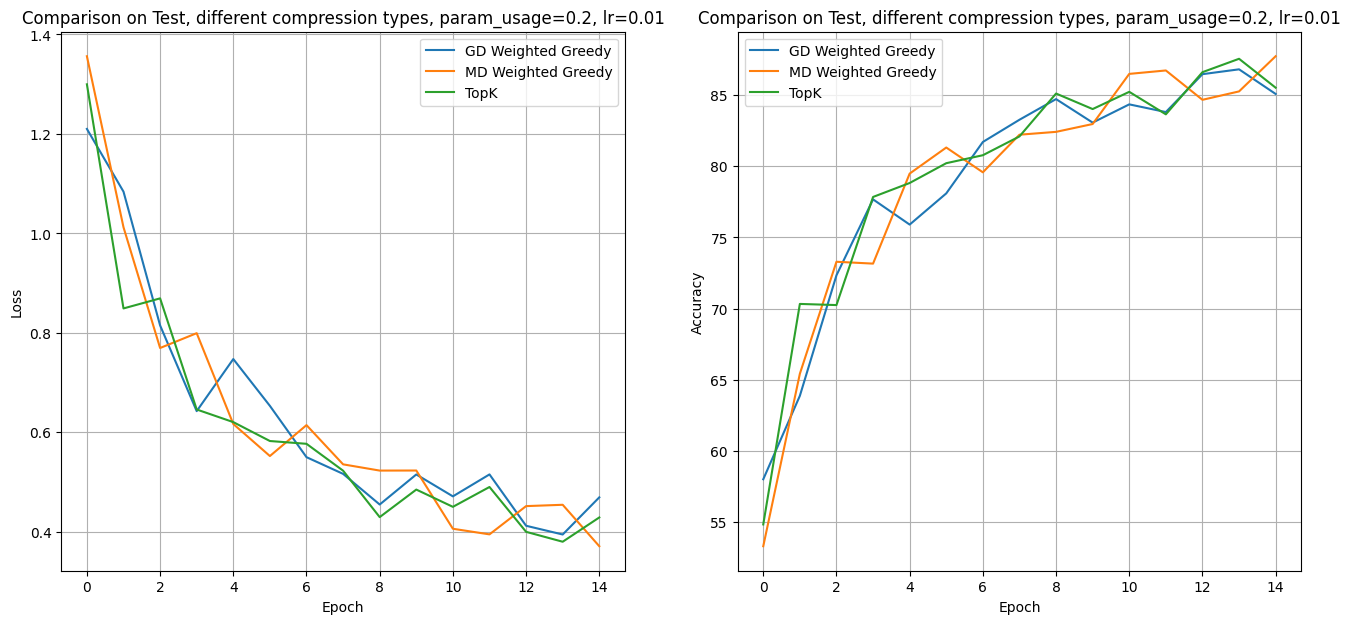

In [41]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_stochastic': 'MD Stochastic',
    'mirror_descent_weighted_greedy': 'MD Weighted Greedy',
    'gradient_descent_weighted_greedy': 'GD Weighted Greedy',
    'mirror_descent_greedy_topk': 'TopK+MD Greedy',
    'mirror_descent_greedy': 'MD Greedy',
    'mirror_descent_greedy_weighted': 'MD Greedy Weighted',
    'random': 'RandK',
    'square_greedy': 'TopK'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2, lr=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2, lr=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

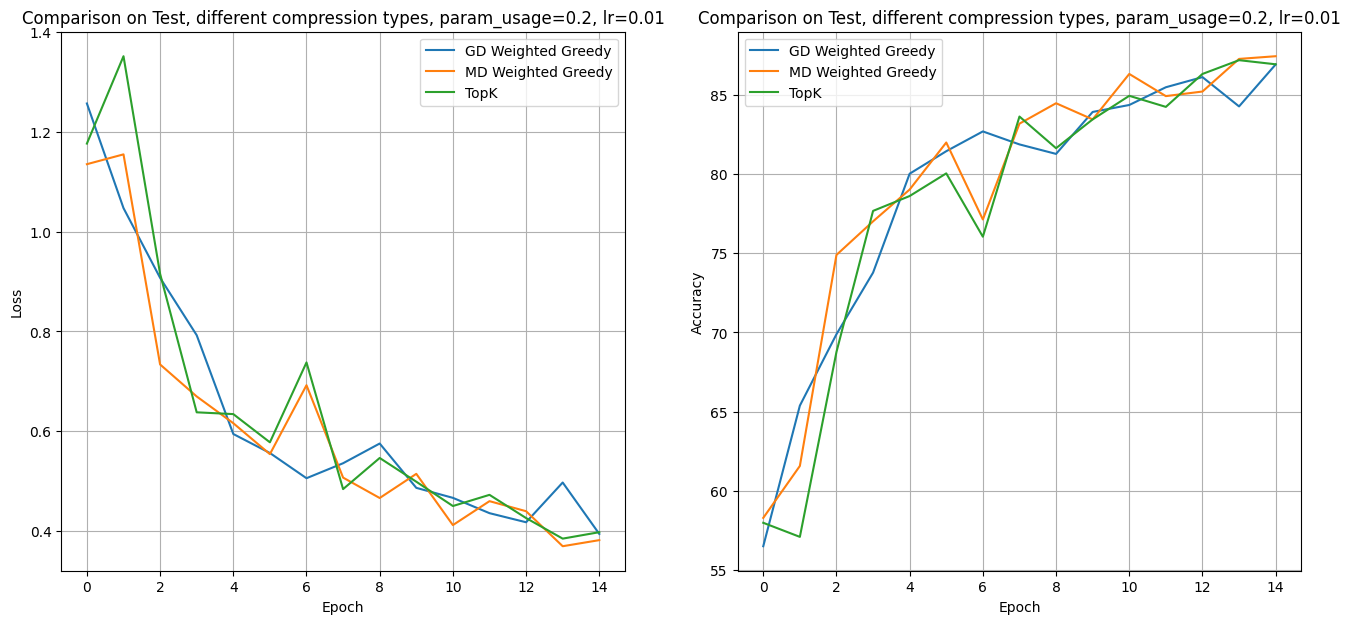

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_stochastic': 'MD Stochastic',
    'mirror_descent_weighted_greedy': 'MD Weighted Greedy',
    'gradient_descent_weighted_greedy': 'GD Weighted Greedy',
    'mirror_descent_greedy_topk': 'TopK+MD Greedy',
    'mirror_descent_greedy': 'MD Greedy',
    'mirror_descent_greedy_weighted': 'MD Greedy Weighted',
    'random': 'RandK',
    'square_greedy': 'TopK'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2, lr=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2, lr=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

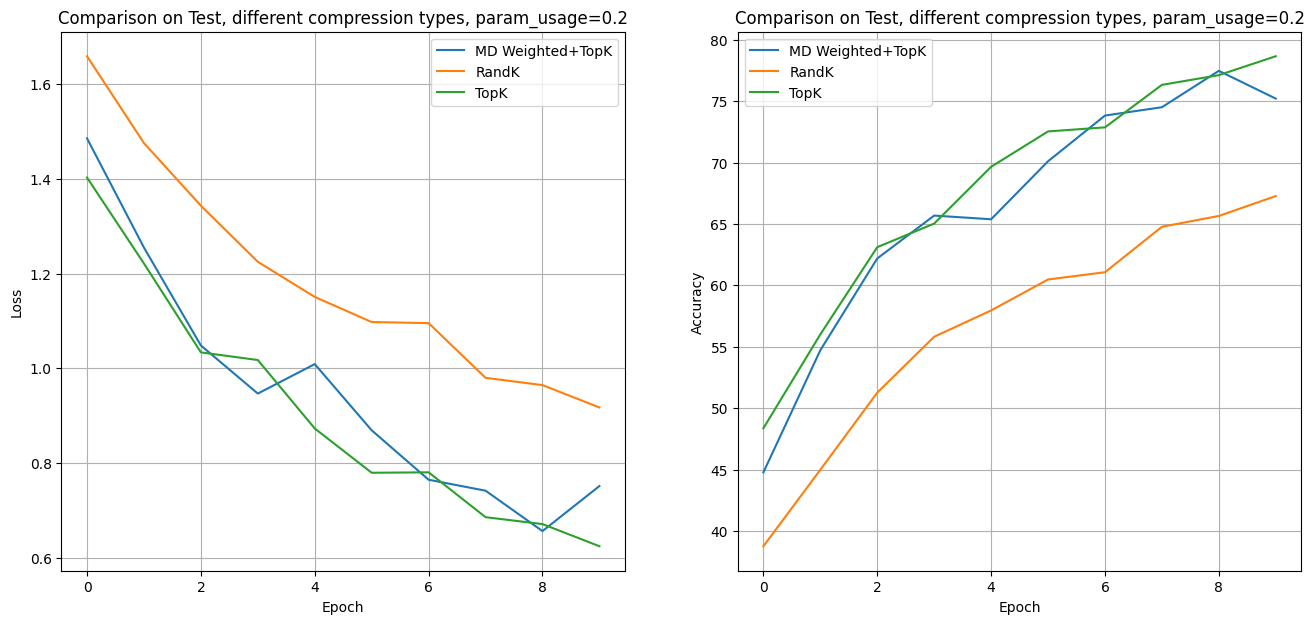

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_weighted_topk': 'MD Weighted+TopK',
    'mirror_descent_greedy_topk': 'TopK+MD Greedy',
    'mirror_descent_greedy': 'MD Greedy',
    'mirror_descent_greedy_weighted': 'MD Weighted',
    'random': 'RandK',
    'square_greedy': 'TopK'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

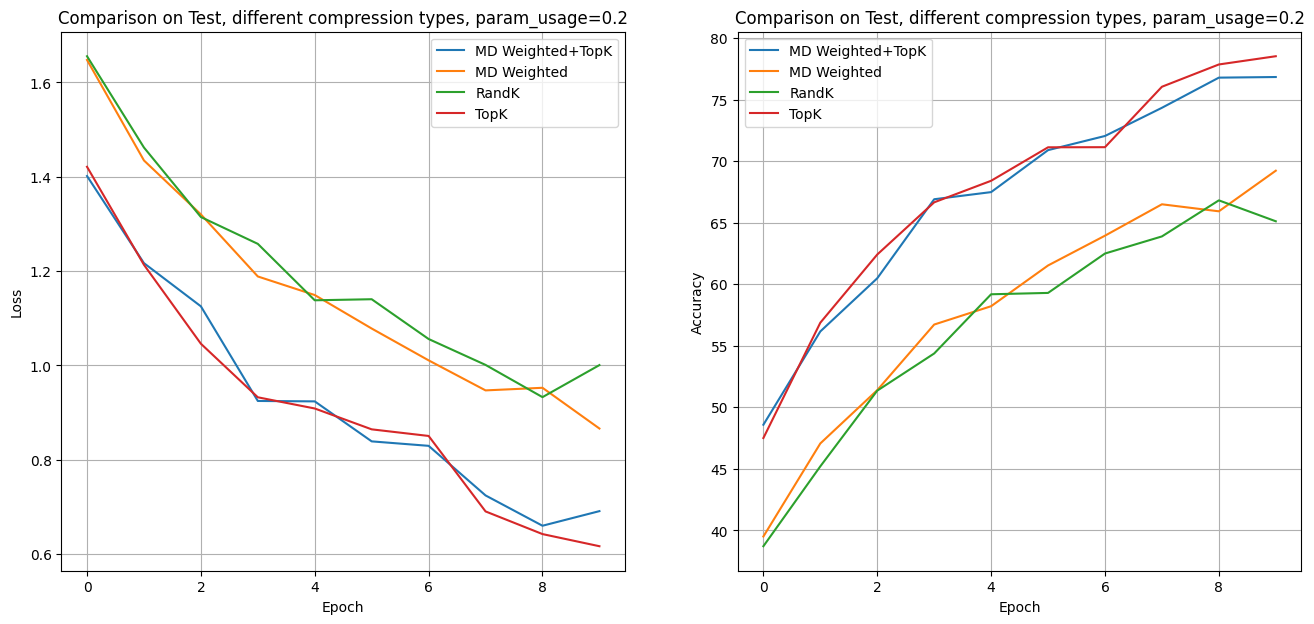

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_weighted_topk': 'MD Weighted+TopK',
    'mirror_descent_greedy_topk': 'TopK+MD Greedy',
    'mirror_descent_greedy': 'MD Greedy',
    'mirror_descent_greedy_weighted': 'MD Weighted',
    'random': 'RandK',
    'square_greedy': 'TopK'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

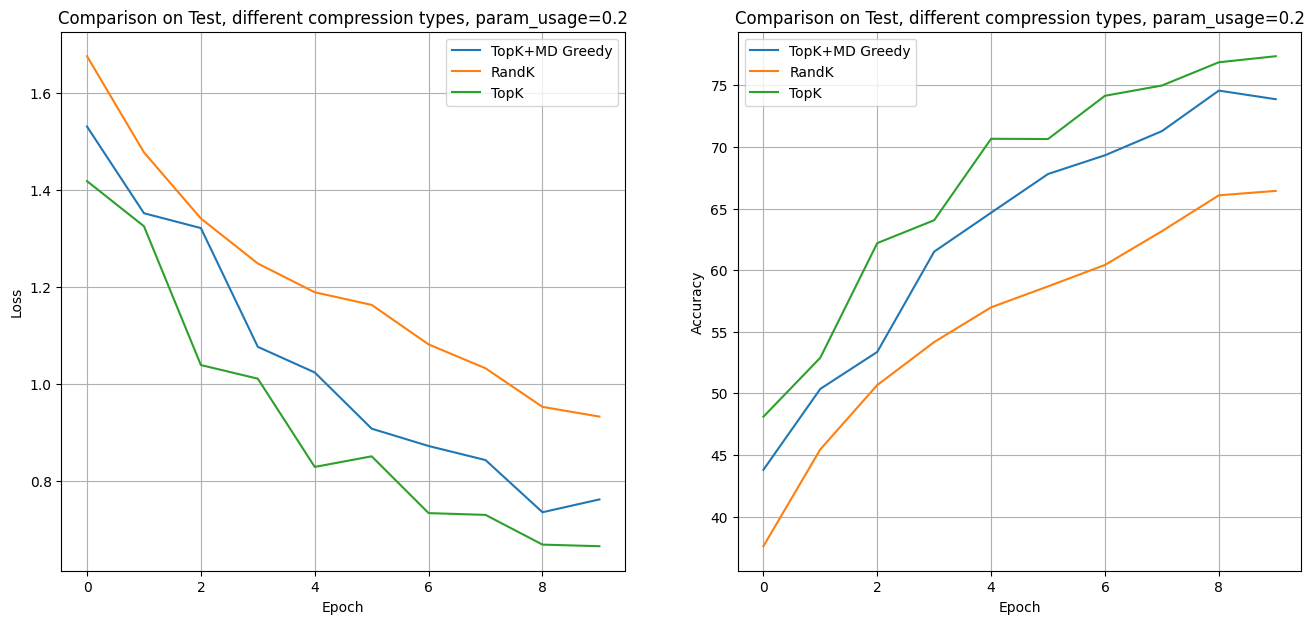

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_greedy_topk': 'TopK+MD Greedy',
    'random': 'RandK',
    'square_greedy': 'TopK'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

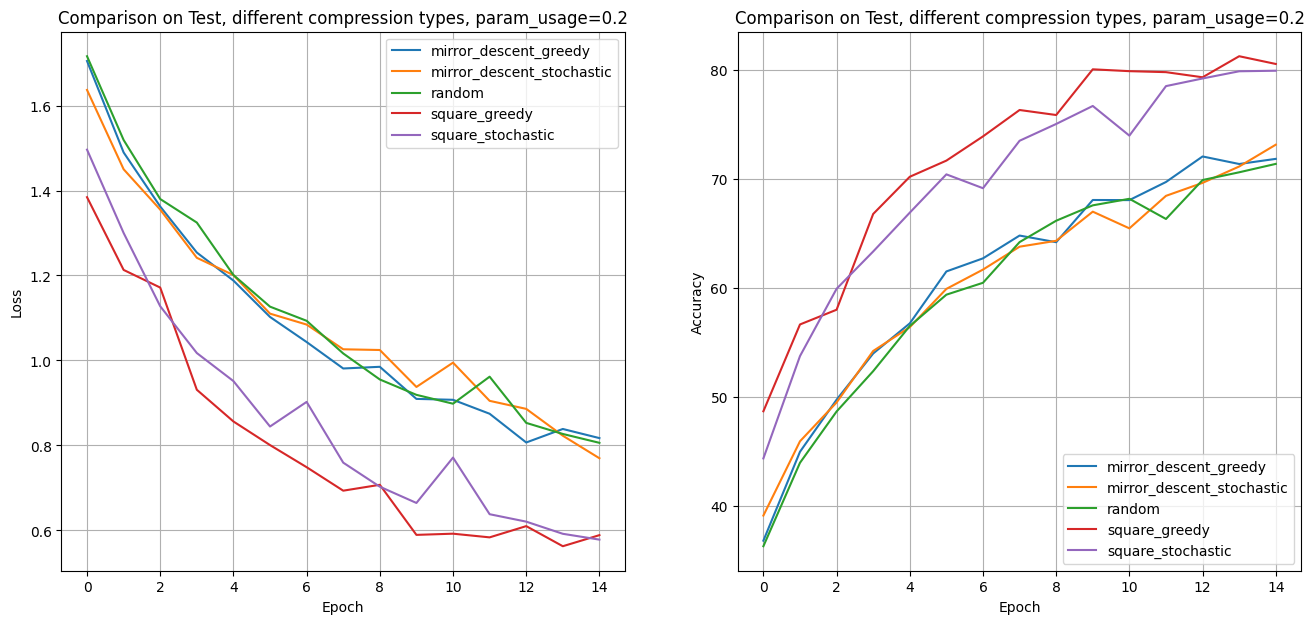

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

for compression_type in compression_types:
    axs[0].plot(test_log[compression_type], label=compression_type)
    axs[1].plot(test_acc[compression_type], label=compression_type)

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

Mirror descent with start point g^2

In [27]:
from math import ceil
from tqdm import tqdm, trange

def train(model, optimizer, criterion, train_dataset, val_dataset, num_epochs, compression_type, lr, param_usage=0.2):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    
    if compression_type == 'mirror_descent_stochastic' or compression_type == 'mirror_descent_greedy':
        w = {name: None
            for name, param in model.named_parameters()
        }
    
    for epoch in trange(num_epochs):
        print('\nEpoch: %d' % epoch)
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(train_dataset):
            inputs, targets = inputs.to(device), targets.to(device)
            if batch_idx == 0 and (compression_type == 'mirror_descent_stochastic' or compression_type == 'mirror_descent_greedy'):
                for name, param in model.named_parameters():
                    if w[name] is None:
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        loss.backward()
                        w[name] = param.grad.detach()**2
                    w[name] = mirror_descent(
                        model=model,
                        param_name=name,
                        impact=w[name],
                        lr=lr,
                        eta=2,
                        lambda_value=1,
                        num_steps=100,
                        X_train=inputs,
                        y_train=targets,
                        criterion=criterion
                    )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            if compression_type == 'square_stochastic':
                for param in model.parameters():
                    w = param.grad.flatten()**2
                    indice = torch.multinomial(w, ceil(param_usage * len(w)))
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'square_greedy':
                for param in model.parameters():
                    w = param.grad.flatten()**2
                    indice = torch.argsort(w, descending=True)[:ceil(param_usage * len(w))]
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'random':
                for param in model.parameters():
                    w = torch.ones_like(param.grad.flatten())
                    indice = torch.multinomial(w, ceil(param_usage * len(w)))
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_stochastic':
                for name, param in model.named_parameters():
                    indice = torch.multinomial(w[name].flatten(), ceil(param_usage * len(w[name].flatten())))
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_greedy':
                for name, param in model.named_parameters():
                    indice = torch.argsort(w[name].flatten(), descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            else:
                raise ValueError(f"Compression type {compression_type} not supported")
            
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_loss /= len(train_dataset)
        train_accuracy = 100. * correct / total
        train_log.append(train_loss)
        train_acc_log.append(train_accuracy)
        
        print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)' % (train_loss, train_accuracy, correct, total))
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_dataset:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        val_loss /= len(val_dataset)
        val_accuracy = 100. * correct / total
        val_log.append(val_loss)
        val_acc_log.append(val_accuracy)
        
        print('Validation Loss: %.3f | Validation Acc: %.3f%% (%d/%d)' % (val_loss, val_accuracy, correct, total))
    
    return train_log, train_acc_log, val_log, val_acc_log

In [28]:
compression_types_extra = ['mirror_descent_greedy', 'mirror_descent_stochastic']
for compression_type in compression_types_extra:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[compression_type], train_acc[compression_type], test_log[compression_type], test_acc[compression_type] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr)

  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.927 | Train Acc: 28.090% (14045/50000)


  7%|▋         | 1/15 [01:30<21:00, 90.00s/it]

Validation Loss: 1.632 | Validation Acc: 39.030% (3903/10000)

Epoch: 1
Train Loss: 1.568 | Train Acc: 42.182% (21091/50000)


 13%|█▎        | 2/15 [02:58<19:16, 88.95s/it]

Validation Loss: 1.480 | Validation Acc: 45.730% (4573/10000)

Epoch: 2
Train Loss: 1.405 | Train Acc: 48.848% (24424/50000)


 20%|██        | 3/15 [04:31<18:12, 91.07s/it]

Validation Loss: 1.304 | Validation Acc: 52.090% (5209/10000)

Epoch: 3
Train Loss: 1.294 | Train Acc: 53.144% (26572/50000)


 27%|██▋       | 4/15 [06:03<16:42, 91.18s/it]

Validation Loss: 1.269 | Validation Acc: 54.200% (5420/10000)

Epoch: 4
Train Loss: 1.206 | Train Acc: 56.454% (28227/50000)


 33%|███▎      | 5/15 [07:31<15:01, 90.15s/it]

Validation Loss: 1.240 | Validation Acc: 55.510% (5551/10000)

Epoch: 5
Train Loss: 1.118 | Train Acc: 59.756% (29878/50000)


 40%|████      | 6/15 [08:59<13:24, 89.40s/it]

Validation Loss: 1.110 | Validation Acc: 60.350% (6035/10000)

Epoch: 6
Train Loss: 1.053 | Train Acc: 62.390% (31195/50000)


 47%|████▋     | 7/15 [10:28<11:53, 89.17s/it]

Validation Loss: 1.034 | Validation Acc: 63.110% (6311/10000)

Epoch: 7
Train Loss: 0.993 | Train Acc: 64.522% (32261/50000)


 53%|█████▎    | 8/15 [11:57<10:24, 89.21s/it]

Validation Loss: 0.985 | Validation Acc: 65.190% (6519/10000)

Epoch: 8
Train Loss: 0.944 | Train Acc: 66.478% (33239/50000)


 60%|██████    | 9/15 [13:24<08:51, 88.56s/it]

Validation Loss: 0.917 | Validation Acc: 67.140% (6714/10000)

Epoch: 9
Train Loss: 0.902 | Train Acc: 67.836% (33918/50000)


 67%|██████▋   | 10/15 [14:51<07:20, 88.12s/it]

Validation Loss: 0.934 | Validation Acc: 66.950% (6695/10000)

Epoch: 10
Train Loss: 0.857 | Train Acc: 69.470% (34735/50000)


 73%|███████▎  | 11/15 [16:20<05:52, 88.24s/it]

Validation Loss: 0.908 | Validation Acc: 68.240% (6824/10000)

Epoch: 11
Train Loss: 0.821 | Train Acc: 71.014% (35507/50000)


 80%|████████  | 12/15 [17:48<04:25, 88.40s/it]

Validation Loss: 0.858 | Validation Acc: 70.070% (7007/10000)

Epoch: 12
Train Loss: 0.787 | Train Acc: 72.138% (36069/50000)


 87%|████████▋ | 13/15 [19:21<02:59, 89.61s/it]

Validation Loss: 0.811 | Validation Acc: 71.700% (7170/10000)

Epoch: 13
Train Loss: 0.754 | Train Acc: 73.426% (36713/50000)


 93%|█████████▎| 14/15 [20:48<01:28, 88.89s/it]

Validation Loss: 0.788 | Validation Acc: 72.560% (7256/10000)

Epoch: 14
Train Loss: 0.722 | Train Acc: 74.680% (37340/50000)


100%|██████████| 15/15 [22:15<00:00, 89.01s/it]


Validation Loss: 0.796 | Validation Acc: 72.310% (7231/10000)


  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.914 | Train Acc: 28.814% (14407/50000)


  7%|▋         | 1/15 [01:35<22:20, 95.75s/it]

Validation Loss: 1.625 | Validation Acc: 40.260% (4026/10000)

Epoch: 1
Train Loss: 1.583 | Train Acc: 41.212% (20606/50000)


 13%|█▎        | 2/15 [03:07<20:11, 93.20s/it]

Validation Loss: 1.455 | Validation Acc: 45.830% (4583/10000)

Epoch: 2
Train Loss: 1.441 | Train Acc: 46.958% (23479/50000)


 20%|██        | 3/15 [04:40<18:36, 93.04s/it]

Validation Loss: 1.366 | Validation Acc: 49.490% (4949/10000)

Epoch: 3
Train Loss: 1.329 | Train Acc: 51.664% (25832/50000)


 27%|██▋       | 4/15 [06:14<17:08, 93.48s/it]

Validation Loss: 1.258 | Validation Acc: 54.130% (5413/10000)

Epoch: 4
Train Loss: 1.238 | Train Acc: 55.210% (27605/50000)


 33%|███▎      | 5/15 [07:46<15:28, 92.89s/it]

Validation Loss: 1.193 | Validation Acc: 56.960% (5696/10000)

Epoch: 5
Train Loss: 1.155 | Train Acc: 58.516% (29258/50000)


 40%|████      | 6/15 [09:17<13:53, 92.57s/it]

Validation Loss: 1.142 | Validation Acc: 59.000% (5900/10000)

Epoch: 6
Train Loss: 1.090 | Train Acc: 60.444% (30222/50000)


 47%|████▋     | 7/15 [10:50<12:19, 92.43s/it]

Validation Loss: 1.076 | Validation Acc: 61.570% (6157/10000)

Epoch: 7
Train Loss: 1.033 | Train Acc: 62.956% (31478/50000)


 53%|█████▎    | 8/15 [12:21<10:44, 92.14s/it]

Validation Loss: 1.025 | Validation Acc: 63.580% (6358/10000)

Epoch: 8
Train Loss: 0.981 | Train Acc: 64.790% (32395/50000)


 60%|██████    | 9/15 [13:53<09:11, 91.96s/it]

Validation Loss: 0.993 | Validation Acc: 64.870% (6487/10000)

Epoch: 9
Train Loss: 0.940 | Train Acc: 66.436% (33218/50000)


 67%|██████▋   | 10/15 [15:23<07:37, 91.44s/it]

Validation Loss: 0.960 | Validation Acc: 66.270% (6627/10000)

Epoch: 10
Train Loss: 0.894 | Train Acc: 68.448% (34224/50000)


 73%|███████▎  | 11/15 [16:52<06:02, 90.73s/it]

Validation Loss: 0.955 | Validation Acc: 66.990% (6699/10000)

Epoch: 11
Train Loss: 0.862 | Train Acc: 69.276% (34638/50000)


 80%|████████  | 12/15 [18:22<04:31, 90.41s/it]

Validation Loss: 0.871 | Validation Acc: 68.980% (6898/10000)

Epoch: 12
Train Loss: 0.823 | Train Acc: 70.662% (35331/50000)


 87%|████████▋ | 13/15 [19:51<02:59, 89.94s/it]

Validation Loss: 0.903 | Validation Acc: 68.530% (6853/10000)

Epoch: 13
Train Loss: 0.790 | Train Acc: 71.960% (35980/50000)


 93%|█████████▎| 14/15 [21:20<01:29, 89.75s/it]

Validation Loss: 0.851 | Validation Acc: 70.420% (7042/10000)

Epoch: 14
Train Loss: 0.766 | Train Acc: 73.002% (36501/50000)


100%|██████████| 15/15 [22:50<00:00, 91.35s/it]

Validation Loss: 0.797 | Validation Acc: 72.440% (7244/10000)


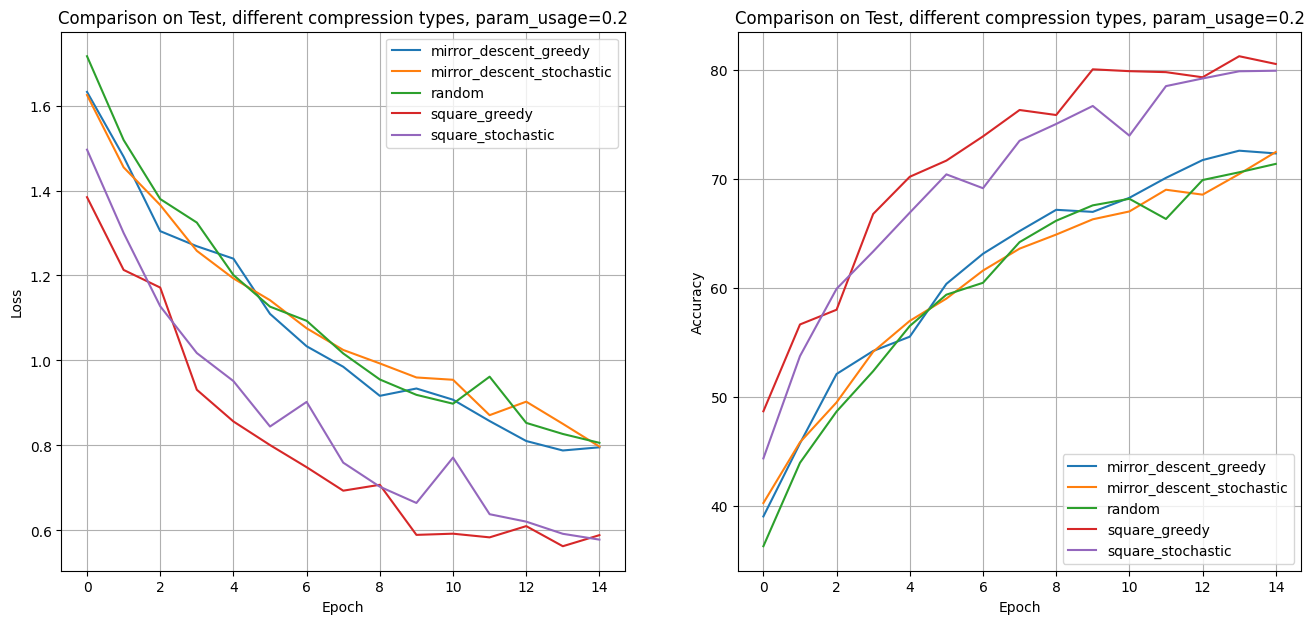

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=compression_type)
    axs[1].plot(test_acc[compression_type], label=compression_type)

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()